In [637]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import pycountry
import pycountry_convert as pc
import geopandas as gpd
from descartes.patch import PolygonPatch
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.cluster import KMeans
import matplotlib as mpl
from xgboost import XGBClassifier

## Reading Data

In [170]:
# data_loc = os.path.join(os.getcwd(), 'Dataset', 'data.csv')
# df = pd.read_csv(data_loc)
df = pd.read_csv('https://www.inf.ed.ac.uk/teaching/courses/fds/data/project-2021-2022/spotify/data.csv.zip')

# Explore how artists and tracks’ popularity varies in time across the global stage

##  1.Do regions share the same top-ranking artists or songs?
##  2.Does the popularity of a track in one region predict its (upcoming?) popularity in other regions ?
##  3.Are there any patterns in what day(s) of the week and/or months experience the most streams? 
##  4.Does reaching the top N (e.g., 5, 10, 20) positions have any relationship with the subsequent lifetime of a track in the data?
##  5.Are there any patterns in what day(s) of the week and/or months experience the most streams?Do these patterns, if any, differ by region?
##  6.Take a ‘deep-dive’ into the work of one (or a collection of) artist(s) and examine trends across their apparent most popular tracks.

# Exploratory Data Analysis (EDA)

## Data Cleaning & Wrangling

### Data Cleaning

In [171]:
# Drop NaN values
df.dropna(subset=['Track Name', 'Artist'], how='all', inplace=True)

# Drop unused column 'URL'
df.drop(columns='URL', inplace=True)

df

,Position,Track Name,Artist,Streams,Date,Region
0,1,Reggaetón Lento (Bailemos),CNCO,19272,2017-01-01,ec
1,2,Chantaje,Shakira,19270,2017-01-01,ec
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,2017-01-01,ec
3,4,Vente Pa' Ca,Ricky Martin,14954,2017-01-01,ec
4,5,Safari,J Balvin,14269,2017-01-01,ec
...,...,...,...,...,...,...
3441192,196,More Than You Know,Axwell /\ Ingrosso,2126,2018-01-09,hk
3441193,197,Issues,Julia Michaels,2117,2018-01-09,hk
3441194,198,Tuo Fei Lun,Eason Chan,2112,2018-01-09,hk
3441195,199,面具,Alfred Hui,2102,2018-01-09,hk


### Data Wrangling

In [172]:
# Change date column to date type
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Turn 'Date' column into three columns 'Year', 'Month', 'Weekday'  
df['Year'] = pd.DatetimeIndex(df.Date).year
df['Month'] = pd.DatetimeIndex(df.Date).month
df['Weekday'] = df['Date'].dt.day_name()

In [173]:
# Convert region codes to corresponding full names
df['Region Code'] = df['Region'].str.upper()

def getRegionName(region):
    if region == 'GLOBAL':
        return region.title()
    return pc.country_alpha2_to_country_name(region,cn_name_format="default")

def getContinentName(region):
    if region == 'GLOBAL':
        return region.title()
    return pc.country_alpha2_to_continent_code(region)

df['Continent'] = df['Region Code'].apply(getContinentName)
df['Region'] = df['Region Code'].apply(getRegionName)

# Replace the abbreviation of continent with corresponding full names
df['Continent'] = df['Continent'].replace({'AS':'Asia', 'EU':'Europe', 'NA':'North America',
                                          'OC':'Oceania','SA':'South America'})

# Reduce the length of some region names
df['Region'] = df['Region'].replace({'Bolivia, Plurinational State of':'Bolivia', 
                                     'Taiwan, Province of China':'Taiwan',
                                     'United States':'United States of America'})

In [400]:
df

,Position,Track Name,Artist,Streams,Date,Region,Year,Month,Weekday,Region Code,Continent
0,1,Reggaetón Lento (Bailemos),CNCO,19272,2017-01-01,Ecuador,2017,1,Sunday,EC,South America
1,2,Chantaje,Shakira,19270,2017-01-01,Ecuador,2017,1,Sunday,EC,South America
2,3,Otra Vez (feat. J Balvin),Zion & Lennox,15761,2017-01-01,Ecuador,2017,1,Sunday,EC,South America
3,4,Vente Pa' Ca,Ricky Martin,14954,2017-01-01,Ecuador,2017,1,Sunday,EC,South America
4,5,Safari,J Balvin,14269,2017-01-01,Ecuador,2017,1,Sunday,EC,South America
...,...,...,...,...,...,...,...,...,...,...,...
3441192,196,More Than You Know,Axwell /\ Ingrosso,2126,2018-01-09,Hong Kong,2018,1,Tuesday,HK,Asia
3441193,197,Issues,Julia Michaels,2117,2018-01-09,Hong Kong,2018,1,Tuesday,HK,Asia
3441194,198,Tuo Fei Lun,Eason Chan,2112,2018-01-09,Hong Kong,2018,1,Tuesday,HK,Asia
3441195,199,面具,Alfred Hui,2102,2018-01-09,Hong Kong,2018,1,Tuesday,HK,Asia


## Data Visualisation for EDA

<AxesSubplot:>

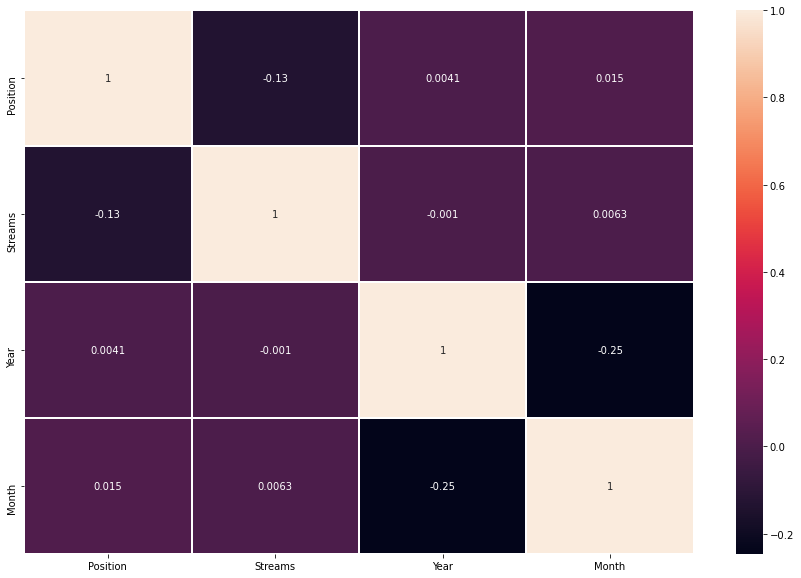

In [405]:
cols_list = df.columns.values.tolist()
cols_list
df_exp = df[cols_list]
plt.figure(figsize=(15,10))
sns.heatmap(df_exp.corr(), annot =True, linewidths = 1)

In [688]:
df_world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
df_streams = df.groupby('Region')['Streams'].sum()
df_world_streams = df_world.merge(df_streams, how="left", left_on=['name'], right_on=['Region'])

Text(0.5, 1.0, 'Streams around the world')

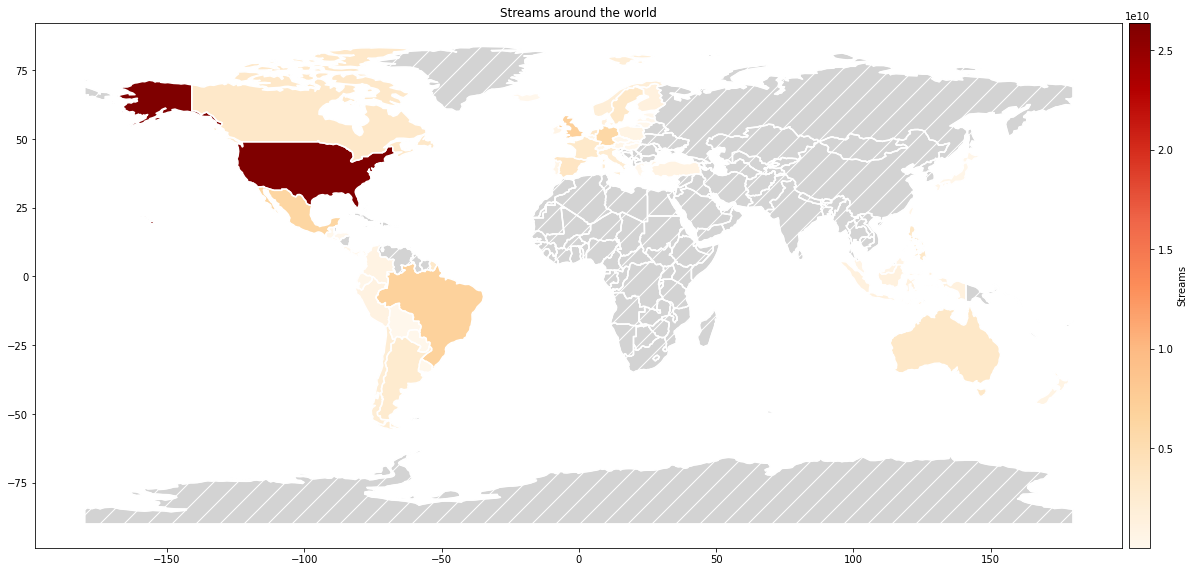

In [71]:
# As a first step, let’s plot the basic map – world with boundary only. 
# In the next steps, we will colour the countries that we are interested in.
ax = df_world["geometry"].boundary.plot(figsize=(20,16), color='white')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad="0.5%")
cax.set_ylabel('Streams')
df_world_streams.plot(column='Streams', ax=ax, cax=cax, cmap='OrRd', 
#                      scheme='quantiles',
                     legend=True, 
#                      legend_kwds={"labels": ['Streams','Streams','Streams','Streams','Streams']},
                     legend_kwds={"label": 'Streams'},
                     missing_kwds={'color': 'lightgrey',
                     "edgecolor": "white", "hatch": "/"})

ax.set_title("Streams around the world")

# Shading the countries that didn’t participate

<Figure size 720x720 with 0 Axes>

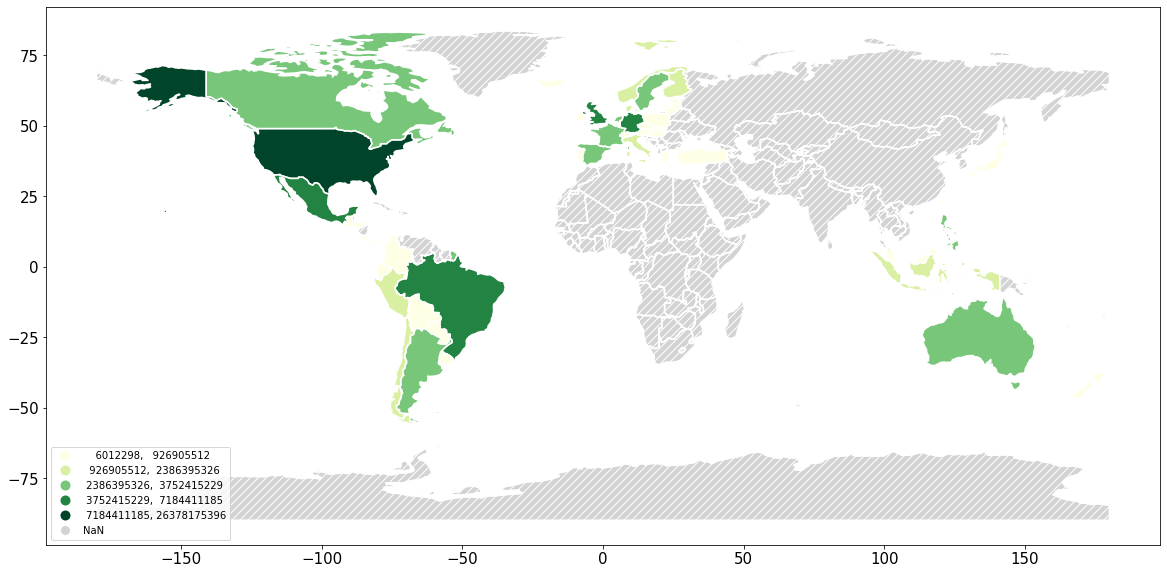

In [836]:
# As a first step, let’s plot the basic map – world with boundary only. 
# In the next steps, we will colour the countries that we are interested in.
# Shading the countries that didn’t participate

fig = plt.figure()
ax = df_world["geometry"].boundary.plot(figsize=(20,18), color='white')
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="2%", pad="0.5%")
# cax.set_ylabel('Streams')
ax = df_world_streams.plot(column='Streams', ax=ax, 
#                      cax=cax, 
                     cmap='YlGn', 
                     scheme='fisher_jenks',
#                      k=10,
                     legend=True, 
#                      legend_kwds={'loc': 'lower left',
#                          "labels": [r'$<1.25x10^8$',
#                                     r'$\geq1.25x10^8$',
#                                     r'$\geq4.09x10^8$',
#                                     r'$\geq9.88x10^8$', 
#                                     r'$\geq3.22x10^9$']},
#                      legend_kwds={"label": 'Streams'},
                     legend_kwds={'loc': 'lower left','fmt':"{:.0f}"},
                     missing_kwds={'color': 'lightgrey',
                     "edgecolor": "white", "hatch": "///"})

ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)

# ax.legend(loc='center right', fontsize=35)
plt.savefig('../world_distribution.png', dpi = 100)

<Figure size 720x720 with 0 Axes>

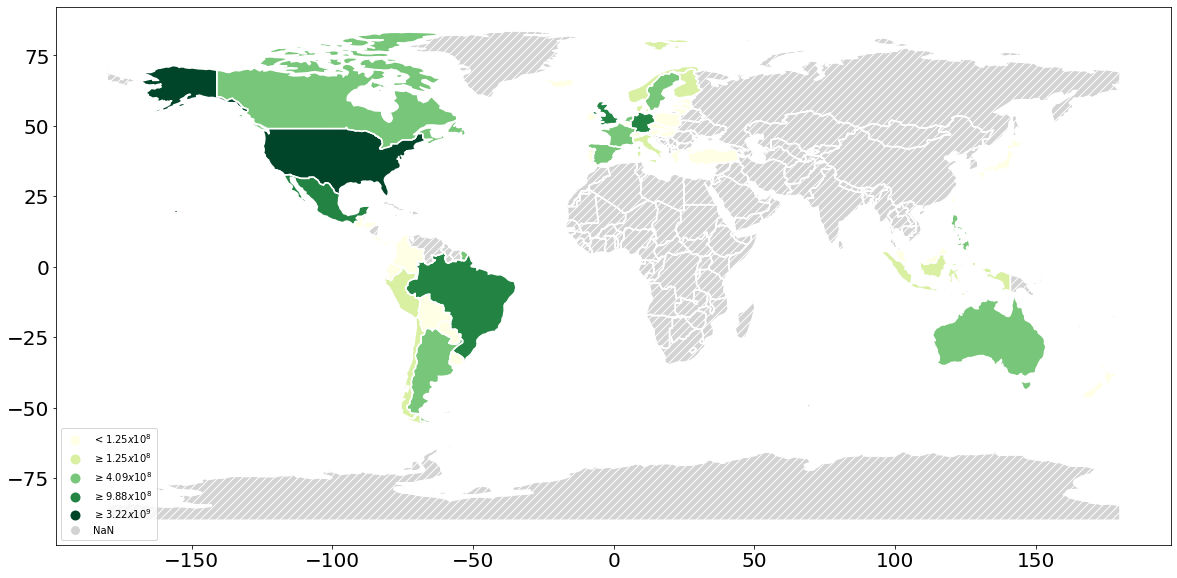

In [837]:
# As a first step, let’s plot the basic map – world with boundary only. 
# In the next steps, we will colour the countries that we are interested in.
# Shading the countries that didn’t participate

fig = plt.figure()
ax = df_world["geometry"].boundary.plot(figsize=(20,18), color='white')
divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="2%", pad="0.5%")
# cax.set_ylabel('Streams')
ax = df_world_streams.plot(column='Streams', ax=ax, 
#                      cax=cax, 
                     cmap='YlGn', 
                     scheme='fisher_jenks',
#                      k=10,
                     legend=True, 
                     legend_kwds={'loc': 'lower left',
                         "labels": [r'$<1.25x10^8$',
                                    r'$\geq1.25x10^8$',
                                    r'$\geq4.09x10^8$',
                                    r'$\geq9.88x10^8$', 
                                    r'$\geq3.22x10^9$']},
#                      legend_kwds={"label": 'Streams'},
#                      legend_kwds={'loc': 'lower left','fmt':"{:.0f}"},
                     missing_kwds={'color': 'lightgrey',
                     "edgecolor": "white", "hatch": "///"})

ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)

# ax.legend(loc='center right', fontsize=35)
plt.savefig('../world_distribution.png', dpi = 100)

In [790]:
df_pie_data = df_streams.to_frame().drop('Global')
pct_value = df_pie_data[lambda x: x.columns[0]].quantile(0.8)
values_below_pct_value = df_pie_data[lambda x: x.columns[0]].loc[lambda s: s < pct_value].index.values
other_list = values_below_pct_value.tolist()
df_pie_data = df_pie_data.reset_index()
def fix_values(row):
    if row['Region'] in other_list:
        row['Region'] = 'Other'
    return row
df_pie_data = df_pie_data.apply(fix_values, axis=1).groupby('Region').agg('sum')
df_pie_data

,Streams
Region,
Australia,3371290725
Brazil,6889016005
Canada,3200384965
Germany,6071522245
Mexico,6341450674
Netherlands,3466573763
Other,28346035634
Philippines,3320110220
Spain,3752415229


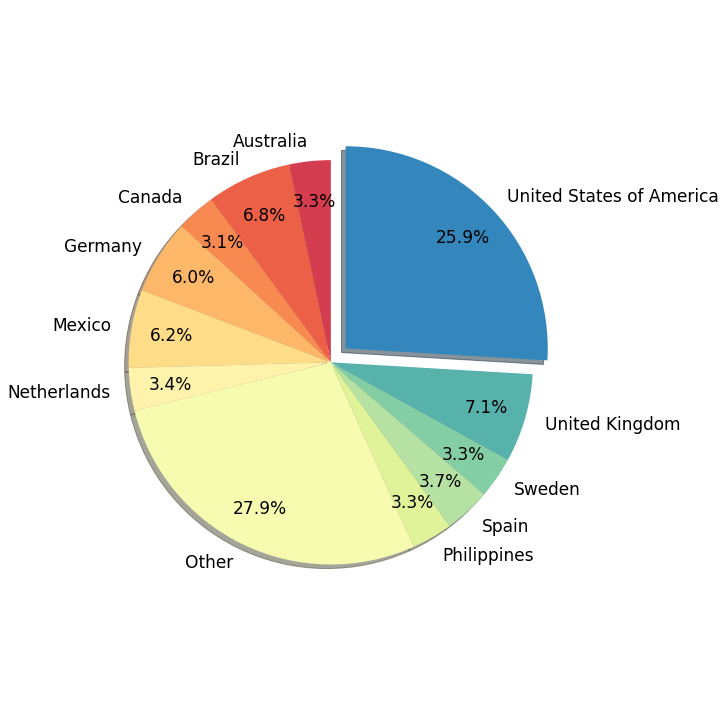

In [838]:
# Pie chart
labels = df_pie_data.index.tolist()
sizes = df_pie_data.Streams.tolist()
explode = tuple([0 if label != 'United States of America' else 0.1 for label in labels])
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0.1, 0.9, len(labels))]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors, 
        textprops={'fontsize': 17}, pctdistance=0.8)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.savefig('../pie_chart.png', dpi = 100)
plt.show()

In [534]:
df_2017 = df[df.Year != 2018]


In [548]:
len(set(df_2017['Track Name'].values.tolist()))

18286

## Extended Dataset

In [564]:
data_loc = os.path.join(os.getcwd(), 'Dataset', 'Features.csv')
df_extended = pd.read_csv(data_loc)
df_extended.drop(
    columns= ['Unnamed: 0','analysis_url','id_caller','id_other','region','track_href', 'type','uri']
    , inplace=True)
df_extended

,Artist,Position,Streams,Track Name,acousticness,danceability,date,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Ed Sheeran,1,51095759,Shape of You,0.5810,0.825,2017-01-06--2017-01-13,233713.0,0.652,0.000000,1.0,0.0931,-3.183,0.0,0.0802,95.977,4.0,0.9310
1,Ed Sheeran,2,35168298,Castle on the Hill,0.0232,0.461,2017-01-06--2017-01-13,261154.0,0.834,0.000011,2.0,0.1400,-4.868,1.0,0.0989,135.007,4.0,0.4710
2,The Weeknd,3,24261229,Starboy,0.1650,0.681,2017-01-06--2017-01-13,230453.0,0.594,0.000003,7.0,0.1340,-7.028,1.0,0.2820,186.054,4.0,0.5350
3,Clean Bandit,4,21671209,Rockabye (feat. Sean Paul & Anne-Marie),0.4060,0.720,2017-01-06--2017-01-13,251088.0,0.763,0.000000,9.0,0.1800,-4.068,0.0,0.0523,101.965,4.0,0.7420
4,ZAYN,5,21513043,I Don’t Wanna Live Forever (Fifty Shades Darke...,0.0631,0.735,2017-01-06--2017-01-13,245200.0,0.451,0.000013,0.0,0.3250,-8.374,1.0,0.0585,117.973,4.0,0.0862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27797,The Chainsmokers,196,4440675,Closer,0.4140,0.748,2019-09-13--2019-09-20,244960.0,0.524,0.000000,8.0,0.1110,-5.599,1.0,0.0338,95.010,4.0,0.6610
27798,Kina,197,4425342,Get You The Moon (feat. Snøw),0.7200,0.498,2019-09-13--2019-09-20,179080.0,0.235,0.000000,1.0,0.1440,-16.541,0.0,0.1880,118.917,4.0,0.0895
27799,Billie Eilish,198,4408380,wish you were gay,0.3900,0.853,2019-09-13--2019-09-20,221543.0,0.351,0.000009,7.0,0.7520,-10.198,1.0,0.2410,118.028,4.0,0.2820
27800,Lil Baby,199,4405555,Drip Too Hard (Lil Baby & Gunna),0.1030,0.896,2019-09-13--2019-09-20,145543.0,0.671,0.000000,1.0,0.5520,-6.977,0.0,0.2890,112.502,4.0,0.3580


In [565]:
# Filter 2017 only
df_extended = df_extended[df_extended.date.str.contains('2017', na=False)]

In [571]:
df_extended.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 10000
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Artist            9995 non-null   object 
 1   Position          10000 non-null  object 
 2   Streams           10000 non-null  object 
 3   Track Name        9995 non-null   object 
 4   acousticness      10000 non-null  float64
 5   danceability      10000 non-null  float64
 6   date              10000 non-null  object 
 7   duration_ms       10000 non-null  float64
 8   energy            10000 non-null  float64
 9   instrumentalness  10000 non-null  float64
 10  key               10000 non-null  float64
 11  liveness          10000 non-null  float64
 12  loudness          10000 non-null  float64
 13  mode              10000 non-null  float64
 14  speechiness       10000 non-null  float64
 15  tempo             10000 non-null  float64
 16  time_signature    10000 non-null  float6

In [572]:
df_extended['Position'] = pd.to_numeric(df_extended['Position'])
df_extended['Streams'] = pd.to_numeric(df_extended['Streams'])

<ipython-input-572-59e68d4641b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extended['Position'] = pd.to_numeric(df_extended['Position'])
<ipython-input-572-59e68d4641b5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extended['Streams'] = pd.to_numeric(df_extended['Streams'])


In [574]:
df_extended

,Artist,Position,Streams,Track Name,acousticness,danceability,date,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Ed Sheeran,1,51095759,Shape of You,0.581000,0.825,2017-01-06--2017-01-13,233713.0,0.652,0.000000,1.0,0.0931,-3.183,0.0,0.0802,95.977,4.0,0.9310
1,Ed Sheeran,2,35168298,Castle on the Hill,0.023200,0.461,2017-01-06--2017-01-13,261154.0,0.834,0.000011,2.0,0.1400,-4.868,1.0,0.0989,135.007,4.0,0.4710
2,The Weeknd,3,24261229,Starboy,0.165000,0.681,2017-01-06--2017-01-13,230453.0,0.594,0.000003,7.0,0.1340,-7.028,1.0,0.2820,186.054,4.0,0.5350
3,Clean Bandit,4,21671209,Rockabye (feat. Sean Paul & Anne-Marie),0.406000,0.720,2017-01-06--2017-01-13,251088.0,0.763,0.000000,9.0,0.1800,-4.068,0.0,0.0523,101.965,4.0,0.7420
4,ZAYN,5,21513043,I Don’t Wanna Live Forever (Fifty Shades Darke...,0.063100,0.735,2017-01-06--2017-01-13,245200.0,0.451,0.000013,0.0,0.3250,-8.374,1.0,0.0585,117.973,4.0,0.0862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,Ozuna,196,3475428,La Modelo,0.213000,0.822,2017-12-29--2018-01-05,256551.0,0.743,0.010300,1.0,0.0957,-2.038,1.0,0.0451,98.005,4.0,0.7800
9997,SZA,197,3461444,The Weekend - Funk Wav Remix,0.495000,0.775,2017-12-29--2018-01-05,171806.0,0.573,0.000000,11.0,0.1260,-4.933,1.0,0.0585,101.925,4.0,0.6670
9998,MC's Jhowzinho & Kadinho,198,3457583,Agora Vai Sentar,0.189000,0.814,2017-12-29--2018-01-05,228923.0,0.653,0.000000,3.0,0.0876,-0.020,0.0,0.0359,130.099,4.0,0.7060
9999,Juan Magán,199,3445360,Déjate Llevar,0.016600,0.675,2017-12-29--2018-01-05,233072.0,0.724,0.000000,7.0,0.6970,-5.503,1.0,0.0787,92.051,4.0,0.5060


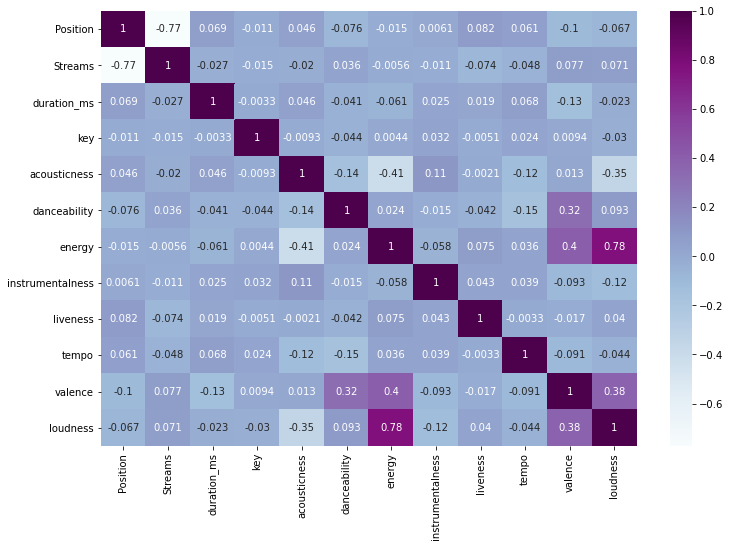

In [588]:
correlation = df_extended[['Position','Streams','duration_ms','key','acousticness','danceability','energy','instrumentalness','liveness','tempo','valence',
                           'loudness']]
# correlation = df_extended[['Position','Streams']]
plt.figure(figsize=(12,8))
sns.heatmap(correlation.corr(), annot=True,cmap="BuPu")
plt.savefig('../FeaturesHeatMap.png', dpi = 100)

In [567]:
correlation.corr()

,acousticness,danceability,energy,instrumentalness,liveness,tempo,valence,loudness
acousticness,1.000000,-0.143797,-0.411934,0.112211,-0.002118,-0.116812,0.012515,-0.348210
danceability,-0.143797,1.000000,0.024048,-0.015072,-0.042185,-0.149559,0.323917,0.092704
energy,-0.411934,0.024048,1.000000,-0.058389,0.074587,0.036271,0.397611,0.776263
instrumentalness,0.112211,-0.015072,-0.058389,1.000000,0.042574,0.038718,-0.093325,-0.116606
liveness,-0.002118,-0.042185,0.074587,0.042574,1.000000,-0.003278,-0.016592,0.040222
tempo,-0.116812,-0.149559,0.036271,0.038718,-0.003278,1.000000,-0.090588,-0.043845
valence,0.012515,0.323917,0.397611,-0.093325,-0.016592,-0.090588,1.000000,0.379978
loudness,-0.348210,0.092704,0.776263,-0.116606,0.040222,-0.043845,0.379978,1.000000


This graph can show that there is a strong correlation between the energy and loudness, whose coeffient is 0.78

##  1.Do regions share the same top-ranking artists or songs?

In [542]:
def plotTopXThings(region, Things, base_on, X = 10, when = 'all'):
    """
    Things: 'Artist'/'Track Name'
    base_on: 'Position'/ 'Streams'
    when: 'all'/'2017'/'2018'
    """
    
    if when == '2017':
        d = df_2017
    else:
        d = df
        
    if base_on == 'Position':
        top = d[d['Region'] == region].loc[(d['Position'] == 1), Things].value_counts()
        top = top.to_frame().reset_index()
        top.columns = [Things, 'Counts']
        topX = top.nlargest(X,'Counts')
        
        x_axis = 'Counts'
        
    elif base_on == 'Streams':
        top = d[d['Region'] == region].groupby(Things)['Streams'].sum()
        top = top.to_frame().reset_index()
        topX = top.nlargest(X,'Streams')
        
        x_axis = 'Streams'
        

    # Declaring the figure or the plot (y, x) or (width, height)
    plt.figure(figsize = (16,10))

    plots = sns.barplot(x= x_axis, y=Things, data=topX)
    
    if base_on == 'Position':
        # Annotating the bar plot with the values (Position 1 counts)
        # Iterrating over the bars one-by-one
        for bar in plots.patches:
            # Using Matplotlib's annotate function and
            plots.annotate(format(bar.get_width(), '.0f'),
                           # passing the coordinates where the annotation shall be done
                           # x-coordinate: 3.5+bar.get_width()
                           # y-coordinate: bar.get_y() + bar.get_height()/2
                           (3.5+bar.get_width(), bar.get_y() + bar.get_height()/2),
                           # ha and va stand for the horizontal and vertical alignment
                           ha='center', va='center')

        # Setting the label for x-axis
        plt.ylabel(Things, size=18)

        # Setting the label for y-axis
        plt.xlabel("Frequency of Reaching Position 1", size=18)
        
        if X >= 50 :
            plt.yticks(fontsize=6)

        # Setting the title for the graph
        plt.title(f"Top-ranking {Things} (Region: {region})", size=22)

        # Finally showing the plot
        return plt.show()

        
    elif base_on == 'Streams':
        # Setting the label for x-axis
        plt.ylabel(Things, size=18)

        # Setting the label for y-axis
        plt.xlabel("Number of Streams", size=18)
        
        if X >= 50 :
            plt.yticks(fontsize=6)

        # Setting the title for the graph
        plt.title(f"Top-ranking {Things} (Region: {region})", size=22)

        # Finally showing the plot
        return plt.show()

### Artist

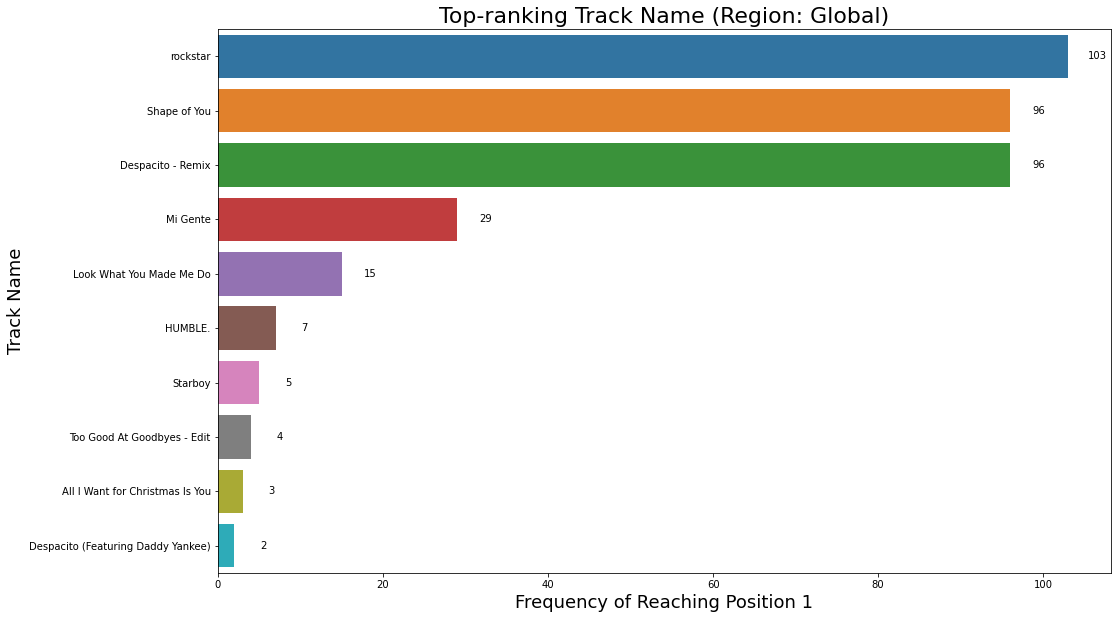

In [544]:
plotTopXThings('Global', 'Track Name', 'Position', when = '2017')
# plotTopXThings('United States of America', 'Artist', 'Streams')
# # plotTopXThings('gb', 'Artist', 'Streams')
# plotTopXThings('Japan', 'Artist', 'Streams')

### Track Name

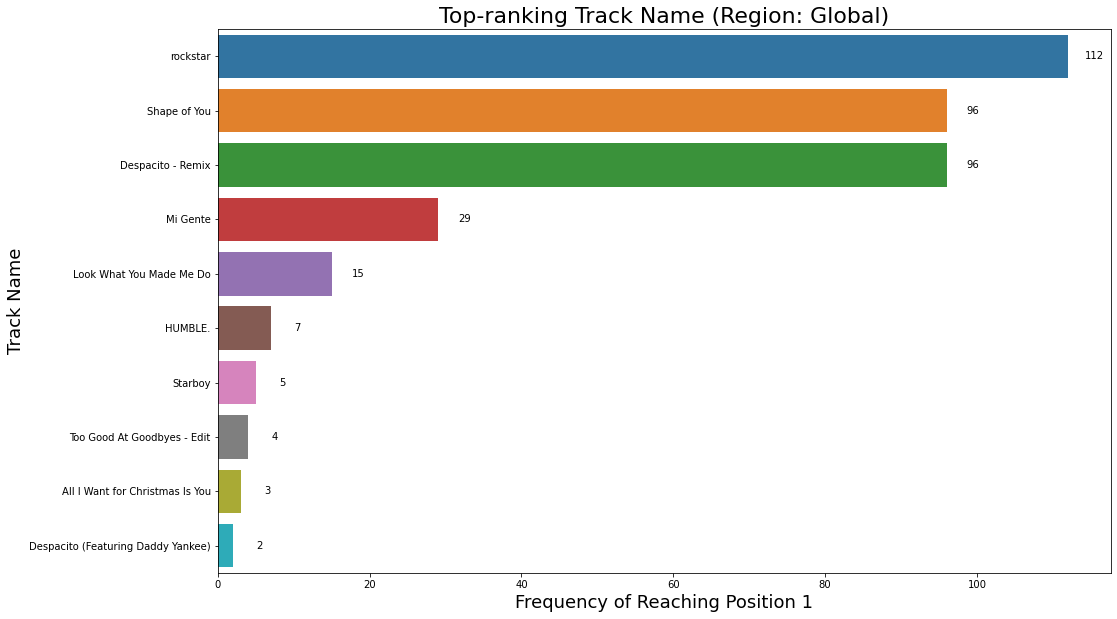

In [540]:
plotTopXThings('Global', 'Track Name', 'Position')
# plotTopXThings('us', 'Track Name', 'Streams')
# plotTopXThings('gb', 'Track Name', 'Streams')
# plotTopXThings('jp', 'Track Name', 'Streams')
# plotTopXThings('tw', 'Track Name', 'Streams')

##  2.Does the popularity of a track in one region predict its (upcoming?) popularity in other regions ?



## 4.Does reaching the top N (e.g., 5, 10, 20) positions have any relationship with the subsequent lifetime of a track in the data?

Hypothesis: The higher position means longer lifetime of a track 

In [22]:
def plotTopXTrend(region,X):
    top = df[df['Region'] == region].groupby(['Track Name','Artist'])['Streams'].sum()
    top = top.to_frame().reset_index()
    topX = top.nlargest(X,'Streams')
    topX_tracks = topX['Track Name'].values.tolist()
    topX_artists = topX['Artist'].values.tolist()
    topX_tuples = list(zip(topX_tracks,topX_artists))
    
    plt.figure(figsize = (16,10))

    for track, artist in topX_tuples:
        d = df[(df['Region'] == region) & (df['Track Name'] == track) & (df['Artist'] == artist)]
        plt.plot(d['Date'], d['Position'], label=track)
        plt.ylim([0, 50])
        plt.yticks(np.arange(1, 201, 10))
        plt.gca().invert_yaxis()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
        plt.gcf().autofmt_xdate()
        plt.legend()

    plt.ylabel('Position', size=18)
    plt.title(f"Trend of Top {X} Tracks (Region: {region})", size=22)
    plt.show()
    


### Trends

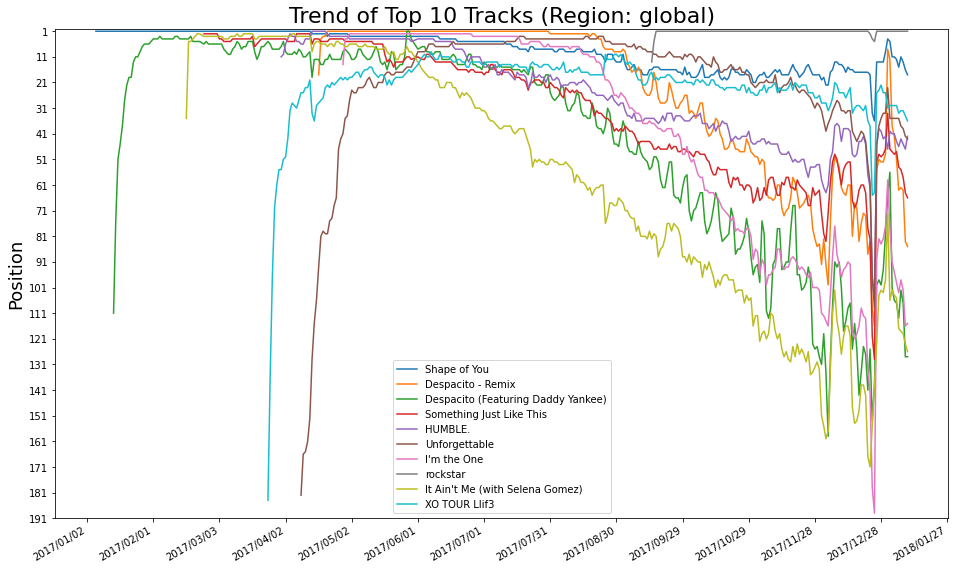

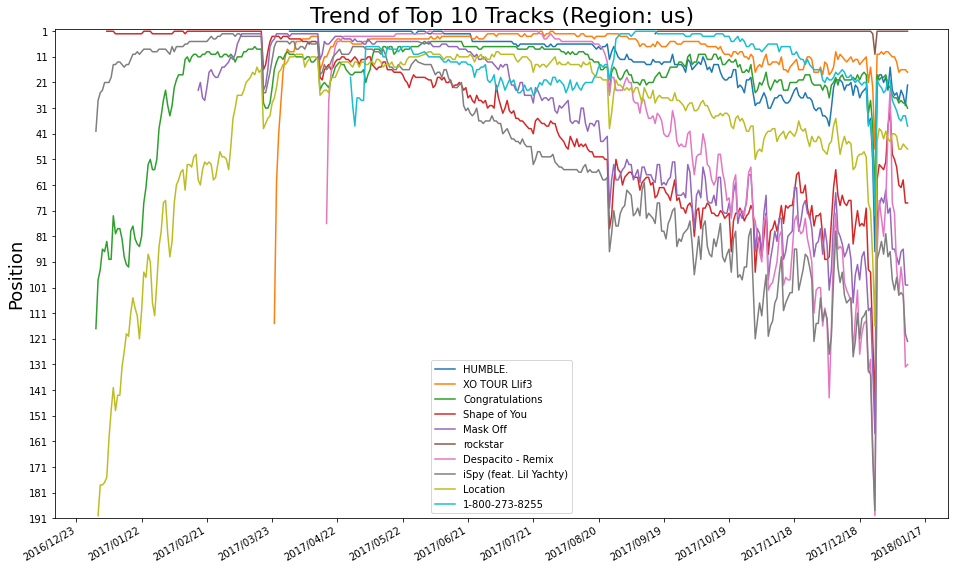

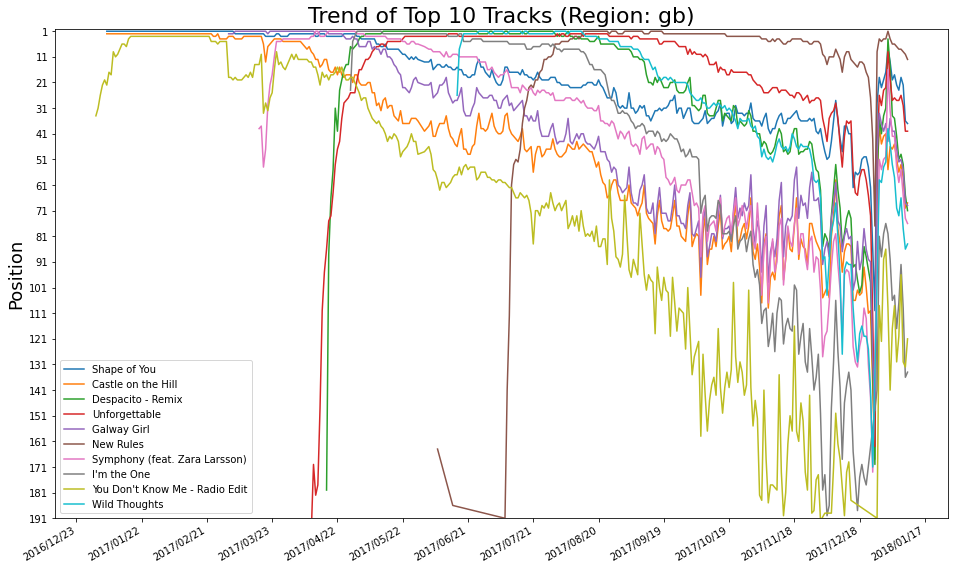

D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 25171 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 33457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 28779 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 25171 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 19978 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Anaconda\lib\site-packages\ma

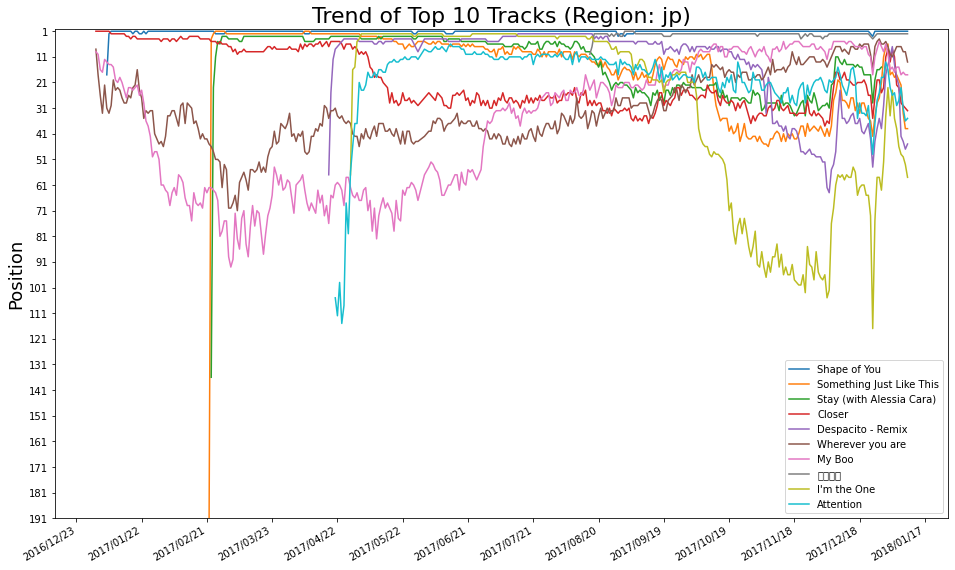

In [23]:
plotTopXTrend('global', 10)
plotTopXTrend('us', 10)
plotTopXTrend('gb', 10)
plotTopXTrend('jp', 10)

In [ ]:
df_ED = df.loc[df['Artist'] == 'Ed Sheeran',:]

df_ED["Date"] = pd.to_datetime(df_ED["Date"])
#Shorten song names
df_ED["Track Name"] = df_ED["Track Name"].apply(lambda x: x[0:15])


total_quantity_by_song_and_date = (df_ED.groupby(
    [df_ED['Date'] , 'Track Name'])['Streams'].sum()
    .reset_index().rename(columns={'Date': 'month'})
    .sort_values('month'))

# Plot the data
ch = chartify.Chart(blank_labels=True, x_axis_type='datetime')
ch.set_title("Stream count of Ed Sheeran's top tracks")
ch.plot.area(
    data_frame=total_quantity_by_song_and_date,
    x_column='month',
    y_column='Streams',
    color_column='Track Name',
    stacked=True)
ch.axes.set_yaxis_range(end = 150000000)
ch.show("png")

## Linear Regression Modeling: Rank Prediction

Multi-output regression is used to predict multiple output/target variables. Artist and streams are used to forecast average/max/min rank variables simultaneously. As tuning /fitting process, after standardizing(scaling) data, PCA is applied to find linear combinations of current predictor variables and created new "principal components". This process helped to reduce dimensionality and understand the most important "directions" in the data. However, after plotting the Linear Regression of actual vs prediction residual I realized that the outcome did not change in proportion to a change in any of the inputs, in other words, the plot indicated nonlinearity

### Simple Linear Regression withdout scaling and PCA

Training Score (R Square): 0.6641.
Testing Score (R Square): 0.654.
RMSE: 34.022.
MAE: 26.833.


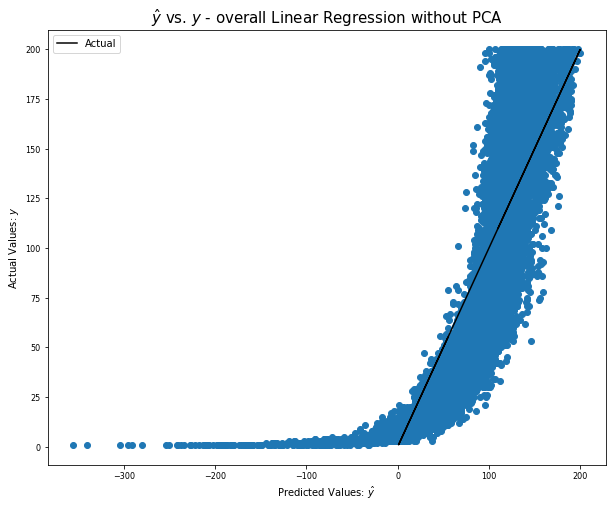

In [493]:
df_Global = df[df['Region Code']=='GLOBAL']

# Dummification of categorical variable 
df_Global_dummies = pd.get_dummies(data=df_Global , columns=['Artist'])
df_Global_dummies.set_index(pd.to_datetime(df_Global_dummies['Date']), inplace = True)

#Choosing matrix 
X = df_Global_dummies.drop(
    columns = ['Date','Year', 'Month', 'Weekday','Region Code', 'Continent', 'Position', 'Track Name', 'Region'])

# defining target
y = df_Global_dummies['Position']

# split data into train/test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Simple Linear Regression ###

#Instantiate and fitting model
lm = LinearRegression()
lm.fit(X_train, y_train)
print(f'Training Score (R Square): {round(lm.score(X_train, y_train),4)}.')
print(f'Testing Score (R Square): {round(lm.score(X_test, y_test),4)}.')

#Look into predictions 
y_pred_train= lm.predict(X_train)
y_pred_test = lm.predict(X_test)
print(f'RMSE: {round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),3)}.')
print(f'MAE: {round(metrics.mean_absolute_error(y_test,y_pred_test),3)}.')

# Plotting to compare actual vs prediction
plt.figure(figsize = (10,8))
plt.scatter(y_pred_test,y_test)
plt.plot( y_test,y_test, c = 'black')
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10)
plt.ylabel("Actual Values: $y$", fontsize = 10)
plt.title("$\hat{y}$ vs. $y$ - overall Linear Regression without PCA", fontsize = 15)
plt.legend(['Actual'])
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.savefig('../LinearRegression.png', dpi = 100)

In [124]:
# model = sm.GLM(y_train, X_train, family = sm.families.Poisson(link = sm.families.links.log)).fit()
# poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
# model.summary()

<ipython-input-124-8f5c6b2a402a>:1: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  model = sm.GLM(y_train, X_train, family = sm.families.Poisson(link = sm.families.links.log)).fit()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               Position   No. Observations:                55338
Model:                            GLM   Df Residuals:                    54896
Model Family:                 Poisson   Df Model:                          441
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.3110e+05
Date:                Sat, 02 Apr 2022   Deviance:                   1.2133e+05
Time:                        15:44:06   Pearson chi2:                 1.91e+05
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
====================================================================================================================
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Streams                                          -1.448e-06   1.52e-09   -952.863      0.000   -1.45e-06   -1.44e-06
Artist_*NSYNC                                        6.1244      0.054    114.048      0.000       6.019       6.230
Artist_187 Strassenbande                             5.7885      0.037    156.784      0.000       5.716       5.861
Artist_2 Chainz                                      5.7368      0.007    861.783      0.000       5.724       5.750
Artist_21 Savage                                     5.7413      0.006   1021.943      0.000       5.730       5.752
Artist_22 Savage                                     5.8985      0.024    249.922      0.000       5.852       5.945
Artist_6LACK                                         5.8601      0.036    161.206      0.000       5.789       5.931
Artist_6ix9ine                                       5.9660      0.014    426.123      0.000       5.939       5.993
Artist_A Boogie Wit da Hoodie                        5.7640      0.006    887.034      0.000       5.751       5.777
Artist_A R I Z O N A                                 5.7143      0.011    501.152      0.000       5.692       5.737
Artist_A$AP Ferg                                     5.7683      0.012    497.784      0.000       5.746       5.791
Artist_A$AP Mob                                      6.0609      0.071     85.709      0.000       5.922       6.200
Artist_AC/DC                                         5.9715      0.045    132.832      0.000       5.883       6.060
Artist_AJR                                           5.7469      0.008    702.114      0.000       5.731       5.763
Artist_ALMA                                          5.8456      0.086     68.167      0.000       5.678       6.014
Artist_Aaron Carter                                  5.7417      0.013    433.410      0.000       5.716       5.768
Artist_Abraham Mateo                                 5.8266      0.008    691.886      0.000       5.810       5.843
Artist_Adele                                         5.7326      0.006    919.945      0.000       5.720       5.745
Artist_Alan Walker                                   5.7656      0.004   1296.685      0.000       5.757       5.774
Artist_Alejandro Fernandez                           5.9260      0.050    117.766      0.000       5.827       6.025
Artist_Alessia Cara                                  5.7792      0.006    967.073      0.000       5.767       5.791
Artist_Alesso                                        5.9130      0.017    346.430      0.000       5.880       5.946
Artist_Alex Sensation                                5.6920      0.011    522.344      0.000       5.671       5.713
Artist_Alok                              

### Linear Regression with Scaling & PCA

Training Score (R Square): 0.5587.
Testing Score (R Square): 0.5543.
RMSE: 38.614.
MAE: 31.458.


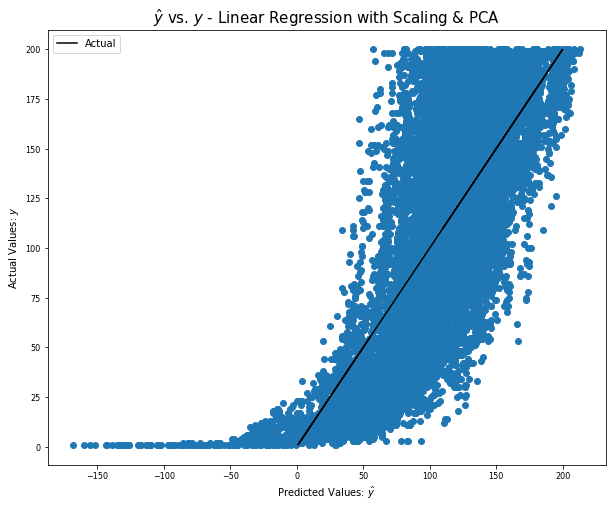

In [494]:
df_Global = df[df['Region Code']=='GLOBAL']

# Dummification of categorical variable 
df_Global_dummies = pd.get_dummies(data=df_Global , columns=['Artist'])
df_Global_dummies.set_index(pd.to_datetime(df_Global_dummies['Date']), inplace = True)

#Choosing matrix 
X = df_Global_dummies.drop(
    columns = ['Date','Year', 'Month', 'Weekday','Region Code', 'Continent', 'Position', 'Track Name', 'Region'])

# defining target
y = df_Global_dummies['Position']

# split data into train/test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

### Linear Regression with Scaling & PCA ###

#Scaling data before running PCA
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

#Instantiate and fit PCA
pca = PCA(n_components=0.9).fit(X_train)

#Instantiate and fitting model
lm = LinearRegression()
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)
lm.fit(Z_train, y_train)
print(f'Training Score (R Square): {round(lm.score(Z_train, y_train),4)}.')
print(f'Testing Score (R Square): {round(lm.score(Z_test, y_test),4)}.')

#Look into predictions 
y_pred_train= lm.predict(Z_train)
y_pred_test = lm.predict(Z_test)
print(f'RMSE: {round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),3)}.')
print(f'MAE: {round(metrics.mean_absolute_error(y_test,y_pred_test),3)}.')

# Plotting to compare actual vs prediction
plt.figure(figsize = (10,8))
plt.scatter(y_pred_test,y_test)
plt.plot( y_test,y_test, c = 'black')
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10)
plt.ylabel("Actual Values: $y$", fontsize = 10)
plt.title("$\hat{y}$ vs. $y$ - Linear Regression with Scaling & PCA", fontsize = 15)
plt.legend(['Actual'])
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
plt.savefig('../LinearRegression.png', dpi = 100)

## Multivariate Linear Regression

### Data Wrangling for Multivariate Linear Regression

In [495]:
# creating new columns/dataframe to be used as matrix for our models
new_cols_rank = df_Global.groupby(['Date','Artist', 'Region']).agg({'Position': ['mean', 'min', 'max']})
new_cols_rank.columns = ['Average Rank', 'Hignest Rank', 'Lowest Rank']

# creating new columns/dataframe to be used as matrix for our models for ranks 
new_cols_streams = df_Global.groupby(['Date', 'Artist','Region']).agg({'Streams': ['mean', 'max', 'min']})
new_cols_streams.columns = ['Average Streams', 'Maximum Streams', 'Minimum Streams']

# merging two DF for consolidated data
df_Global_new = pd.merge(new_cols_rank, new_cols_streams, on =['Date', 'Region', 'Artist'])
df_Global_new.reset_index(level=['Region','Artist'], inplace = True)

# dummification of categorical variable
df_Global_new_dummies = pd.get_dummies(data=df_Global_new, columns=['Artist'])

In [501]:
# Choosing target
y_new = df_Global_new_dummies[['Lowest Rank', 'Hignest Rank', 'Average Rank']]

X_new = df_Global_new_dummies.drop(
    columns = ['Region', 'Lowest Rank', 'Hignest Rank', 'Average Rank'])

# split data into test/train sets 
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state = 42)

# Scaling data for PCA 
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

# Instantiate PCA and fitting
pca = PCA(n_components=0.9).fit(X_train)

### Model: Multivariate Linear Regression with only Scaling & PCA

In [502]:
# Tune & fit model 
mlr_model = MultiOutputRegressor(LinearRegression())
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)
mlr_model.fit(Z_train, y_train)
print(f'Training Score (R Square Score): {round(mlr_model.score(Z_train, y_train),4)}.')
print(f'Testing Score (R Square Score): {round(mlr_model.score(Z_test, y_test),4)}.')

#Look into predictions 
y_pred_train= mlr_model.predict(Z_train)
y_pred_test = mlr_model.predict(Z_test)
print(f'RMSE of Trainng set: {round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)),3)}.')
print(f'RMSE of Testing set: {round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),3)}.')
print(f'MAE of Trainng set: {round(metrics.mean_absolute_error(y_train,y_pred_train),3)}.')
print(f'MAE of Testing set: {round(metrics.mean_absolute_error(y_test,y_pred_test),3)}.')

Training Score (R Square Score): 0.7165.
Testing Score (R Square Score): 0.7071.
RMSE of Trainng set: 29.58.
RMSE of Testing set: 30.163.
MAE of Trainng set: 23.052.
MAE of Testing set: 23.493.


### Model: Multivariate Linear Regression with RandomForest Regressor 

In [505]:
#Tuning model & Fit it 
mlr_model_rf = MultiOutputRegressor(RandomForestRegressor())
Z_train_rf = pca.transform(X_train)
Z_test_rf = pca.transform(X_test)
mlr_model_rf.fit(Z_train_rf, y_train)
print(f'Training Score (R Square Score): {round(mlr_model_rf.score(Z_train_rf, y_train),4)}.')
print(f'Testing Score (R Square Score): {round(mlr_model_rf.score(Z_test_rf, y_test),4)}.')

# Look into predictions 
y_pred_train_rf= mlr_model_rf.predict(Z_train_rf)
y_pred_test_rf = mlr_model_rf.predict(Z_test_rf)
print(f'RMSE of Testing set: {round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_rf)),3)}.')
print(f'RMSE of Trainng set: {round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_rf)),3)}.')
print(f'MAE of Testing set: {round(metrics.mean_absolute_error(y_test,y_pred_test_rf),3)}.')
print(f'MAE of Trainng set: {round(metrics.mean_absolute_error(y_train,y_pred_train_rf),3)}.')

Training Score (R Square Score): 0.9932.
Testing Score (R Square Score): 0.9478.
RMSE of Testing set: 12.662.
RMSE of Trainng set: 4.573.
MAE of Testing set: 8.372.
MAE of Trainng set: 3.035.


### Models Comparison

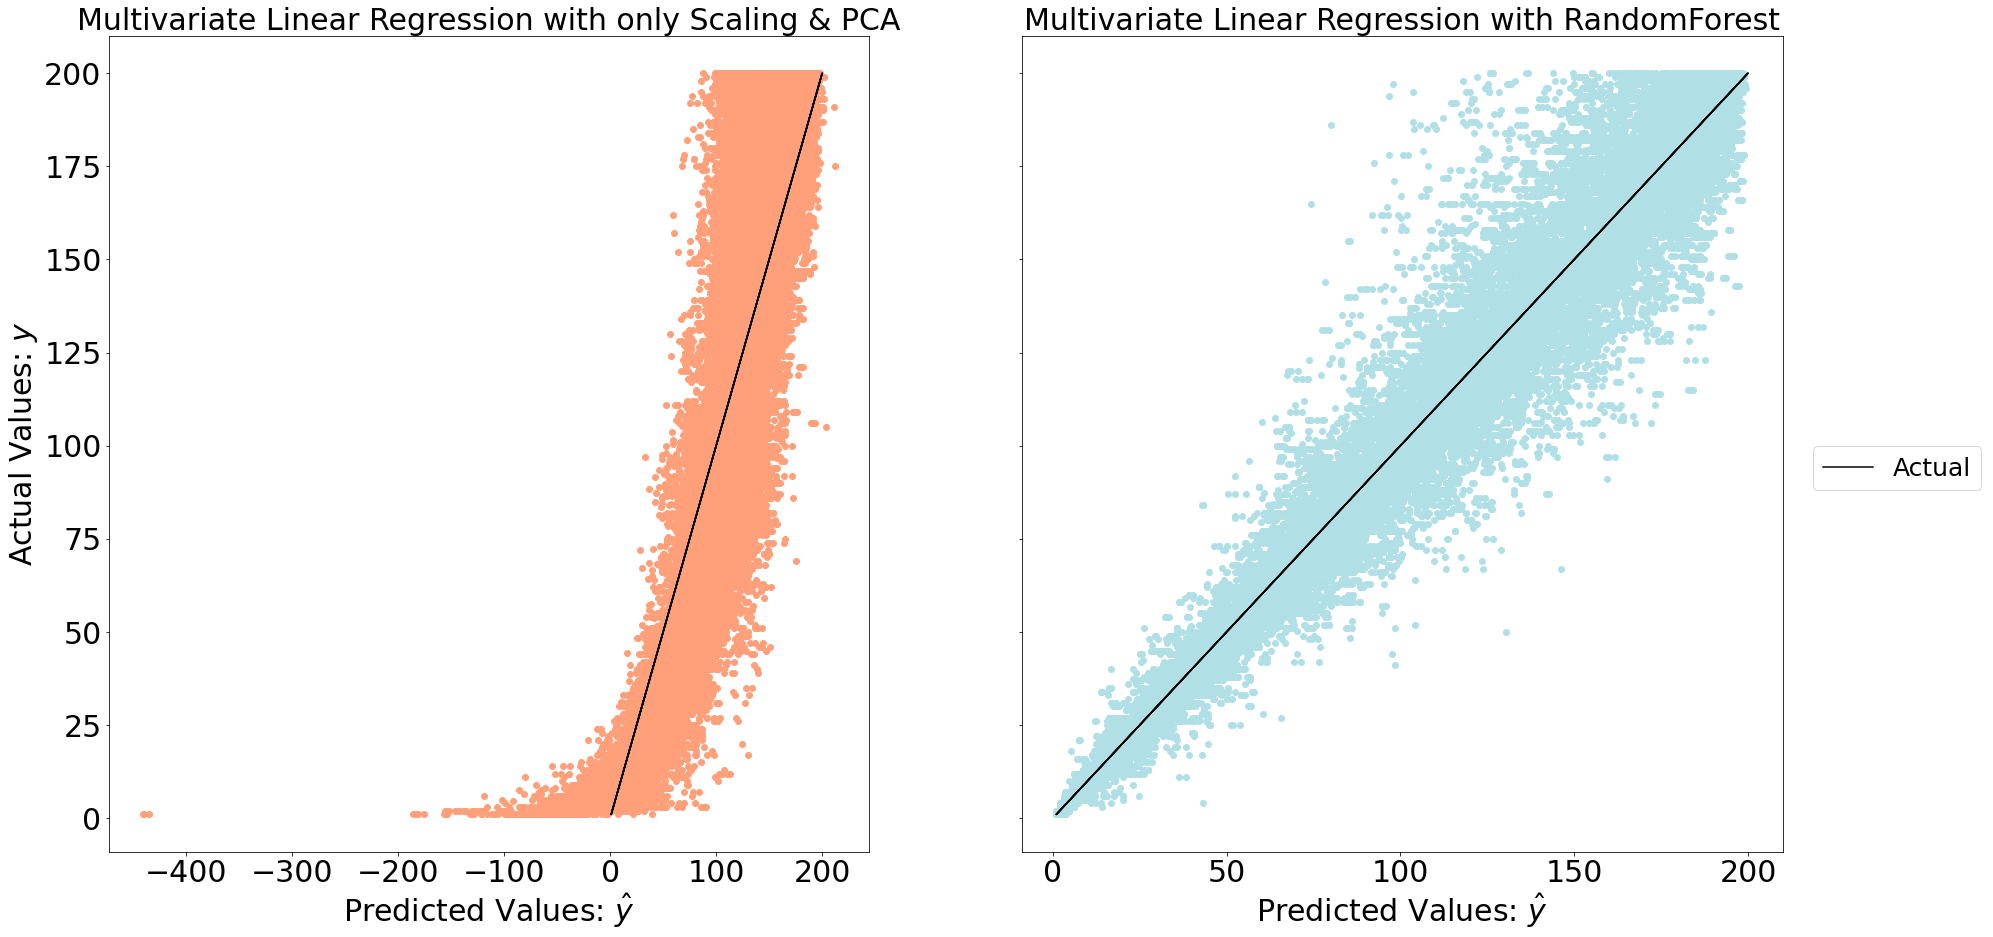

In [578]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15), sharey=True)

### Plotting to compare actual vs preds for Multivariate Linear Regression with only Scaling & PCA
ax1.scatter(y_pred_test, y_test, c = 'lightsalmon')
ax1.plot(y_test, y_test, c = 'black')
ax1.set_title("Multivariate Linear Regression with only Scaling & PCA", fontsize = 30)
ax1.set_xlabel("Predicted Values: $\hat{y}$", fontsize=30)
ax1.set_ylabel("Actual Values: $y$", fontsize=30)
ax1.yaxis.set_tick_params(labelsize=30)
ax1.xaxis.set_tick_params(labelsize=30)

### Plotting to compare actual vs preds for Multivariate Linear Regression with RandomForest Regressor 
ax2.scatter(y_pred_test_rf, y_test, c = 'powderblue')
ax2.plot(y_test, y_test, c = 'black')
ax2.set_title("Multivariate Linear Regression with RandomForest", fontsize =30)
ax2.set_xlabel("Predicted Values: $\hat{y}$", fontsize=30)
ax2.yaxis.set_tick_params(labelsize=30)
ax2.xaxis.set_tick_params(labelsize=30)

fig.legend(['Actual'],loc='center right', fontsize=25)
fig.savefig('../residual_rank_rf_overall.png', dpi = 100)

### Model: Multivariate Linear Regression with RandomForest Regressor But No Scaling&PCA

Training Score (R Square Score): 0.9927.
Testing Score (R Square Score): 0.9464.
RMSE of Testing set: 12.84.
RMSE of Trainng set: 4.72.
MAE of Testing set: 8.658.
MAE of Trainng set: 3.165.


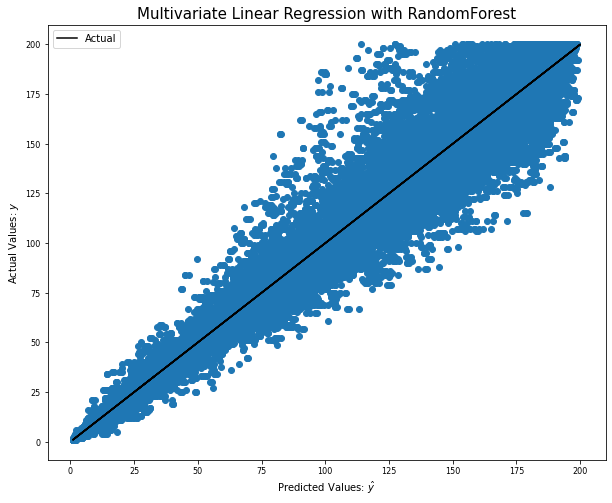

In [500]:
# Choosing target
y_new = df_Global_new_dummies[['Lowest Rank', 'Hignest Rank', 'Average Rank']]

X_new = df_Global_new_dummies.drop(
    columns = ['Region', 'Lowest Rank', 'Hignest Rank', 'Average Rank'])

# split data into test/train sets 
X_train, X_test, y_train, y_test = train_test_split(X_new, y_new, random_state = 42)

#Tuning model & Fit it 
rf = MultiOutputRegressor(RandomForestRegressor())
rf.fit(X_train, y_train)
print(f'Training Score (R Square Score): {round(rf.score(X_train, y_train),4)}.')
print(f'Testing Score (R Square Score): {round(rf.score(X_test, y_test),4)}.')

# Look into predictions 
y_pred_train_rf= rf.predict(X_train)
y_pred_test_rf = rf.predict(X_test)
print(f'RMSE of Testing set: {round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_rf)),3)}.')
print(f'RMSE of Trainng set: {round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_rf)),3)}.')
print(f'MAE of Testing set: {round(metrics.mean_absolute_error(y_test,y_pred_test_rf),3)}.')
print(f'MAE of Trainng set: {round(metrics.mean_absolute_error(y_train,y_pred_train_rf),3)}.')

# Plotting to compare actual vs preds for average rank 
plt.figure(figsize = (10,8))
plt.scatter(y_pred_test_rf,y_test);
plt.plot( y_test,y_test, c = 'black');
plt.xlabel("Predicted Values: $\hat{y}$", fontsize = 10);
plt.ylabel("Actual Values: $y$", fontsize = 10);
plt.title("Multivariate Linear Regression without RandomForest", fontsize = 15);
plt.legend(['Actual']);
plt.yticks(fontsize=8)
plt.xticks(fontsize=8);
plt.savefig('../residual_overall_random_forest.png', dpi = 100)

In [582]:
preds_test_rf = pd.DataFrame(y_pred_test_rf)
preds_test_rf.columns=['Average Rank Prediction', 'Hignest Rank Prediction', 'Lowest Rank Prediction']

preds_train_rf = pd.DataFrame(y_pred_test_rf)
preds_train_rf.columns=['Average Rank Prediction', 'Hignest Rank Prediction', 'Lowest Rank Prediction']

In [583]:
# selecting relevant column for seperate assessment
y_test_avg = y_test['Average Rank']
y_test_hi = y_test['Hignest Rank']
y_test_low = y_test['Lowest Rank']

y_train_avg = y_train['Average Rank']
y_train_hi = y_train['Hignest Rank']
y_train_low = y_train['Lowest Rank']

# creating Dataframe for predictions
y_pred_test_avg = preds_test_rf['Average Rank Prediction']
y_pred_test_hi = preds_test_rf['Hignest Rank Prediction']
y_pred_test_low = preds_test_rf['Lowest Rank Prediction']

y_pred_train_avg = preds_train_rf['Average Rank Prediction']
y_pred_train_hi = preds_train_rf['Hignest Rank Prediction']
y_pred_train_low = preds_train_rf['Lowest Rank Prediction']

Text(0.5, 0.98, 'Rank Prediction by using Random Forest')

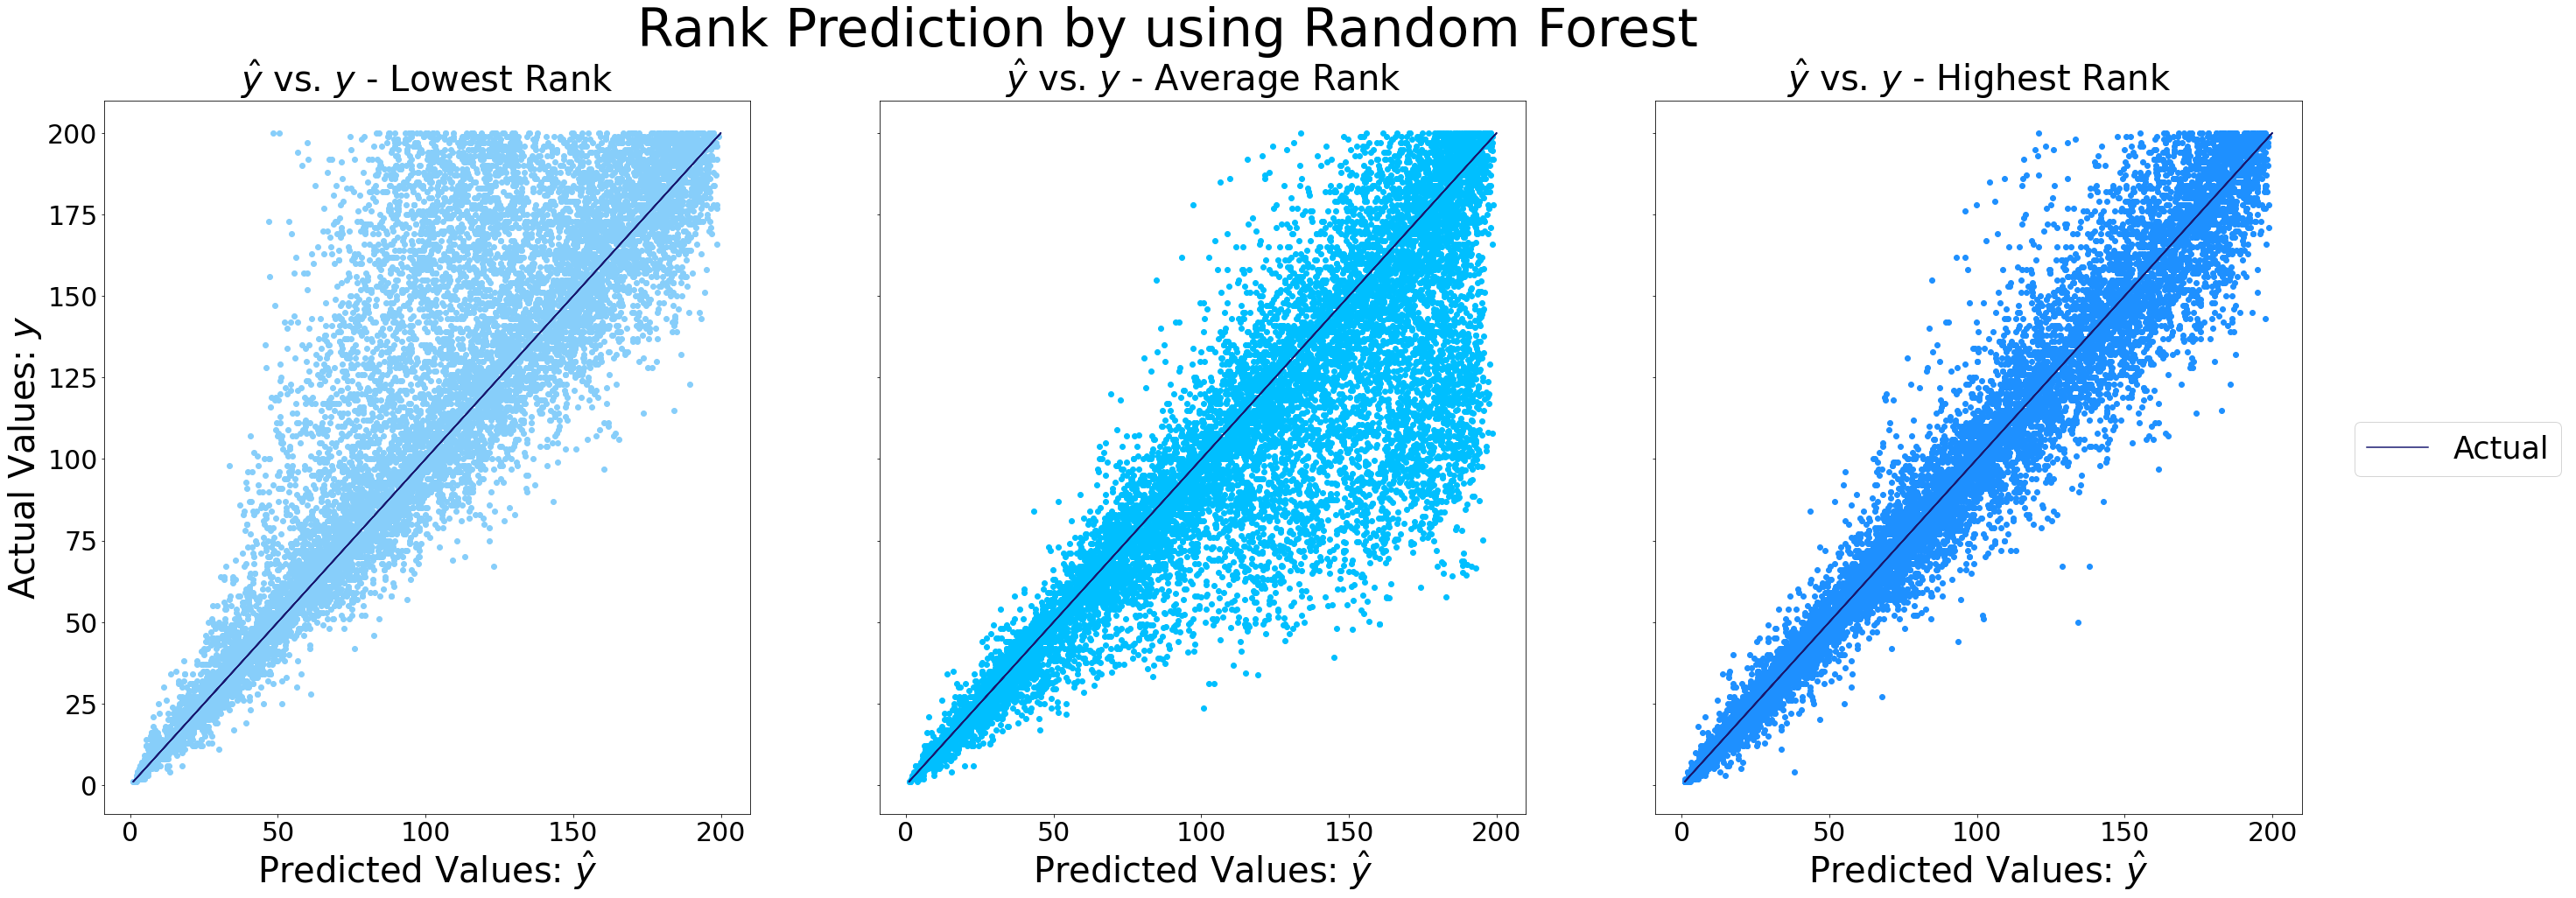

In [579]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(45, 15), sharey=True)

### Plotting to compare actual vs preds for low rank 
ax1.scatter(y_pred_test_low,y_test_low, c = 'lightskyblue')
ax1.plot( y_test,y_test, c = 'midnightblue')
ax1.set_title("$\hat{y}$ vs. $y$ - Lowest Rank", fontsize = 40)
ax1.set_xlabel("Predicted Values: $\hat{y}$", fontsize=40)
ax1.set_ylabel("Actual Values: $y$", fontsize=40)
ax1.yaxis.set_tick_params(labelsize=30)
ax1.xaxis.set_tick_params(labelsize=30)

### Plotting to compare actual vs preds for avg rank 
ax2.scatter(y_pred_test_avg,y_test_avg, c = 'deepskyblue')
ax2.plot( y_test,y_test, c = 'midnightblue')
ax2.set_title("$\hat{y}$ vs. $y$ - Average Rank", fontsize = 40)
ax2.set_xlabel("Predicted Values: $\hat{y}$", fontsize=40)
ax2.yaxis.set_tick_params(labelsize=30)
ax2.xaxis.set_tick_params(labelsize=30)

### Plotting to compare actual vs preds for highest rank 
ax3.scatter(y_pred_test_hi,y_test_hi, c = 'dodgerblue')
ax3.plot( y_test,y_test, c = 'midnightblue')
ax3.set_title("$\hat{y}$ vs. $y$ - Highest Rank", fontsize = 40)
ax3.set_xlabel("Predicted Values: $\hat{y}$", fontsize=40)
ax3.yaxis.set_tick_params(labelsize=30)
ax3.xaxis.set_tick_params(labelsize=30)

fig.legend(['Actual'],loc='center right', fontsize=35)
fig.savefig('../residual_rank_rf.png', dpi = 100)
fig.suptitle('Rank Prediction by using Random Forest', fontsize=60)

There are 3 main metrics for model evaluation in regression:
* R Square/Adjusted R Square
* Mean Square Error(MSE)/Root Mean Square Error(RMSE)
* Mean Absolute Error(MAE)

In [585]:
print('RMSE Train - Overall:', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_rf)))
print('RMSE Test - Overall:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test_rf)))
# print('RMSE Train - Average Rank:', np.sqrt(metrics.mean_squared_error(y_train_avg, y_pred_train_avg)))
print('RMSE Test - Average Rank:', np.sqrt(metrics.mean_squared_error(y_test_avg, y_pred_test_avg)))
# print('RMSE Train - Top Rank:', np.sqrt(metrics.mean_squared_error(y_train_avg, y_pred_train_hi)))
print('RMSE Test - Top Rank:',np.sqrt(metrics.mean_squared_error(y_test_hi, y_pred_test_hi)))
# print('RMSE Train -Low Rank:',np.sqrt(metrics.mean_squared_error(y_train_low, y_pred_train_low)))
print('RMSE Test -Low Rank:',np.sqrt(metrics.mean_squared_error(y_test_low, y_pred_test_low)))



RMSE Train - Overall: 4.573359330555962
RMSE Test - Overall: 12.661631754327848
RMSE Test - Average Rank: 29.703908779150375
RMSE Test - Top Rank: 12.09384219586228
RMSE Test -Low Rank: 30.61832261087303


#### Mean Absolute Error

In [586]:
# TRAIN - Mean Absolute Error represents median distance from the predicted value.
metrics.mean_absolute_error(y_train,y_pred_train_rf)

3.0347576274091943

In [587]:
#TEST - Mean Absolute Error represents median distance from the predicted value.
metrics.mean_absolute_error(y_test,y_pred_test_rf)

8.372494540674227

## Clustering
Here is some unsupervised learning analysis. Each song in the data set will be a feature. The value will be the percentage of plays for each song by country

In [590]:
# create the features by first calculating percentage of plays in a country for each song
cluster = df.copy()
cluster['Artist_Trackname'] = cluster['Artist'] + ' ' + cluster['Track Name']

# get the total plays for each track by country
cluster['Total_Song_Plays'] = cluster.groupby(['Region', 'Artist_Trackname'])['Streams'].transform('sum')

# get the total plays in total for each country
cluster['Total_Plays'] = cluster.groupby(['Region'])['Streams'].transform('sum')

# drop duplicate rows
cluster = cluster[['Artist_Trackname', 'Total_Song_Plays', 'Total_Plays', 'Region', 'Continent','Region Code']].drop_duplicates()

# calculate the percentage of plays that were for each song
cluster['Percent_Plays'] = cluster['Total_Song_Plays'] / cluster['Total_Plays']

# pivot the table to get the features
cluster = cluster.pivot(index='Region Code', columns='Artist_Trackname', values='Percent_Plays')

# pivot table creates NaN values when there is no value. In reality, these values should be zero.
cluster = cluster.fillna(0)

cluster

Artist_Trackname,#TocoParaVos Bailemos juntos,#TocoParaVos Enganchado #TocoParaVos - Cumbia Mix,#TocoParaVos Hasta la luna,#TocoParaVos Me provoca (Noche loca),#TocoParaVos Su fiel admirador,#TocoParaVos Sólo necesito,#TocoParaVos Tan infinito,#TocoParaVos Tengo un vicio,#TocoParaVos Tu beso y tu piel (feat. Gustas Mio),#TocoParaVos Uh amor (feat. Lionel Ferro),...,黃義達 到底多久,黃義達 匿名的寶貝,黃義達 每天的每夜,黃聖萊Lex 看好,黃荻鈞 半年,黄靖伦 我會一直記得,黄靖伦 舊傷,鼓鼓 為愛而愛,齊晨 到此為止,龔詩嘉 My Island Home
Region Code,,,,,,,,,,,,,,,,,,,,,
AR,0.000000,0.000014,0.000772,0.000000,0.000000,0.000005,0.000000,0.000000,0.000005,0.000005,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
AU,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
BR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CH,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [622]:
pca = PCA(n_components=3)
pca_features = pca.fit_transform(cluster)
Region_code = cluster.index
pca_results = pd.DataFrame(pca_features, columns=['f1', 'f2','f3'])
pca_results['Region Code'] = Region_code
pca_results['Continent'] = pca_results['Region Code'].apply(getContinentName)
pca_results['Region Name'] = pca_results['Region Code'].apply(getRegionName)

# Replace the abbreviation of continent with corresponding full names
pca_results['Continent'] = pca_results['Continent'].replace({'AS':'Asia', 'EU':'Europe', 'NA':'North America',
                                          'OC':'Oceania','SA':'South America'})

# Reduce the length of some region names
pca_results['Region'] = pca_results['Region Name'].replace({'Bolivia, Plurinational State of':'Bolivia', 
                                     'Taiwan, Province of China':'Taiwan',
                                     'United States':'United States of America'})

pca_results =  pca_results.loc[(pca_results['Continent'] != 'Global')]
pca_results

,f1,f2,f3,Region Code,Continent,Region Name,Region
0,0.053687,0.002267,-0.001721,AR,South America,Argentina,Argentina
1,-0.019797,-0.006728,-0.005807,AT,Europe,Austria,Austria
2,-0.024785,-0.011558,0.000495,AU,Oceania,Australia,Australia
3,-0.021072,-0.003217,-0.002809,BE,Europe,Belgium,Belgium
4,0.059860,0.012930,0.002208,BO,South America,"Bolivia, Plurinational State of",Bolivia
5,-0.002579,-0.022316,-0.006956,BR,South America,Brazil,Brazil
6,-0.021079,-0.010443,-0.008710,CA,North America,Canada,Canada
7,-0.016166,0.000599,-0.006045,CH,Europe,Switzerland,Switzerland
8,0.055789,-0.000266,-0.001535,CL,South America,Chile,Chile
9,0.047901,0.005299,0.001750,CO,South America,Colombia,Colombia


### K Means

In [644]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(cluster)

In [842]:
pca = PCA(n_components = 8)
pca.fit(cluster)
pca.explained_variance_ratio_

array([0.45542495, 0.13636172, 0.0403856 , 0.03949614, 0.03295455,
       0.02353029, 0.01931774, 0.01803009])

In [651]:
# pca = PCA(n_components = 10)
# pca.fit(segmentation_std)
# pca.explained_variance_ratio_

array([0.08621148, 0.0538478 , 0.05113146, 0.05054353, 0.04850452,
       0.04707057, 0.04456052, 0.04163507, 0.03923345, 0.03562397])

Text(0, 0.5, 'Explained Variance')

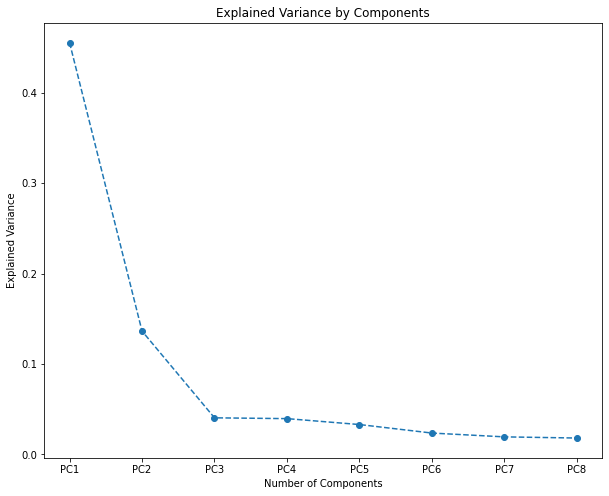

In [844]:
plt.figure(figsize = (10,8))
plt.plot(['PC'+str(i) for i in range(1,9)], pca.explained_variance_ratio_, marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

In [653]:
pca = PCA(n_components = 3)
pca.fit(cluster)
scores_pca = pca.transform(cluster)

In [656]:
wcss = []
for i in range(1,21):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++',random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

D:\Anaconda\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [657]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=20, random_state=42)

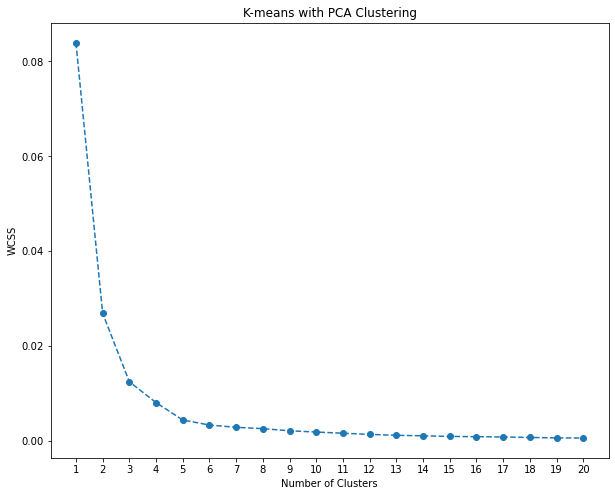

In [660]:
plt.figure(figsize = (10,8))
plt.plot([str(i) for i in range(1,21)], wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering')
plt.show()

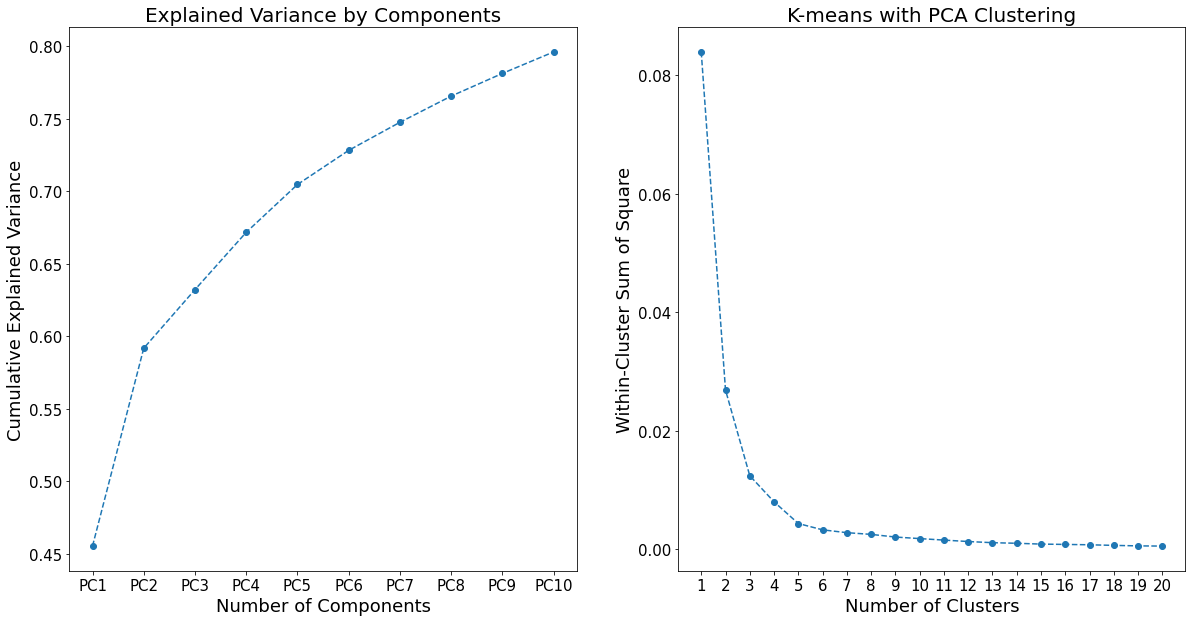

In [681]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.plot(['PC'+str(i) for i in range(1,11)], pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
ax1.set_title('Explained Variance by Components',fontsize=20)
ax1.set_xlabel('Number of Components',fontsize=18)
ax1.set_ylabel('Cumulative Explained Variance',fontsize=18)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.xaxis.set_tick_params(labelsize=15)

ax2.plot([str(i) for i in range(1,21)], wcss, marker = 'o', linestyle = '--')
ax2.set_title('K-means with PCA Clustering',fontsize=20)
ax2.set_xlabel('Number of Clusters',fontsize=18)
ax2.set_ylabel("Within-Cluster Sum of Square",fontsize=18)
ax2.yaxis.set_tick_params(labelsize=15)
ax2.xaxis.set_tick_params(labelsize=15)

fig.savefig('../n_cluster_selection.png', dpi = 100)

And from this graph, we determine the number of clusters we’d like to keep. To that effect, we use the Elbow-method. The approach consists of looking for a kink or elbow in the WCSS graph. Usually, the part of the graph before the elbow would be steeply declining, while the part after it – much smoother. In this instance, we’ll be keeping a three-cluster solution.

In [662]:
kmeans_pca = KMeans(n_clusters = 3, init = 'k-means++', random_state = 42)

In [663]:
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=3, random_state=42)

In [673]:
df_cluster_pca_kmeans = pd.concat([cluster.reset_index(), pd.DataFrame(scores_pca)], axis = 1)
df_cluster_pca_kmeans['Continent'] = df_cluster_pca_kmeans['Region Code'].apply(getContinentName)
df_cluster_pca_kmeans['Region Name'] = df_cluster_pca_kmeans['Region Code'].apply(getRegionName)

# Replace the abbreviation of continent with corresponding full names
df_cluster_pca_kmeans['Continent'] = df_cluster_pca_kmeans['Continent'].replace({'AS':'Asia', 'EU':'Europe', 'NA':'North America',
                                          'OC':'Oceania','SA':'South America'})

# Reduce the length of some region names
df_cluster_pca_kmeans['Region'] = df_cluster_pca_kmeans['Region Name'].replace({'Bolivia, Plurinational State of':'Bolivia', 
                                     'Taiwan, Province of China':'Taiwan',
                                     'United States':'United States of America'})

df_cluster_pca_kmeans.columns.values[-6:-3] = ['PC1','PC2','PC3']
# df_cluster_pca_kmeans.columns.values[-3:] = ['PC1','PC2','PC3']
df_cluster_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
df_cluster_pca_kmeans = df_cluster_pca_kmeans.loc[(df_cluster_pca_kmeans['Continent'] != 'Global')]
df_cluster_pca_kmeans

,Region Code,#TocoParaVos Bailemos juntos,#TocoParaVos Enganchado #TocoParaVos - Cumbia Mix,#TocoParaVos Hasta la luna,#TocoParaVos Me provoca (Noche loca),#TocoParaVos Su fiel admirador,#TocoParaVos Sólo necesito,#TocoParaVos Tan infinito,#TocoParaVos Tengo un vicio,#TocoParaVos Tu beso y tu piel (feat. Gustas Mio),...,鼓鼓 為愛而愛,齊晨 到此為止,龔詩嘉 My Island Home,PC1,PC2,PC3,Continent,Region Name,Region,Segment K-means PCA
0,AR,0.000000,0.000014,0.000772,0.000000,0.000000,0.000005,0.000000,0.000000,0.000005,...,0.000000,0.000000,0.000000,0.053687,0.002267,-0.001722,South America,Argentina,Argentina,1
1,AT,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.019797,-0.006728,-0.005809,Europe,Austria,Austria,0
2,AU,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.024785,-0.011558,0.000495,Oceania,Australia,Australia,0
3,BE,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.021072,-0.003217,-0.002810,Europe,Belgium,Belgium,0
4,BO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.059860,0.012930,0.002207,South America,"Bolivia, Plurinational State of",Bolivia,1
5,BR,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.002579,-0.022316,-0.006956,South America,Brazil,Brazil,0
6,CA,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.021079,-0.010443,-0.008710,North America,Canada,Canada,0
7,CH,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.016166,0.000599,-0.006045,Europe,Switzerland,Switzerland,0
8,CL,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.055789,-0.000266,-0.001535,South America,Chile,Chile,1
9,CO,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.047901,0.005299,0.001750,South America,Colombia,Colombia,1


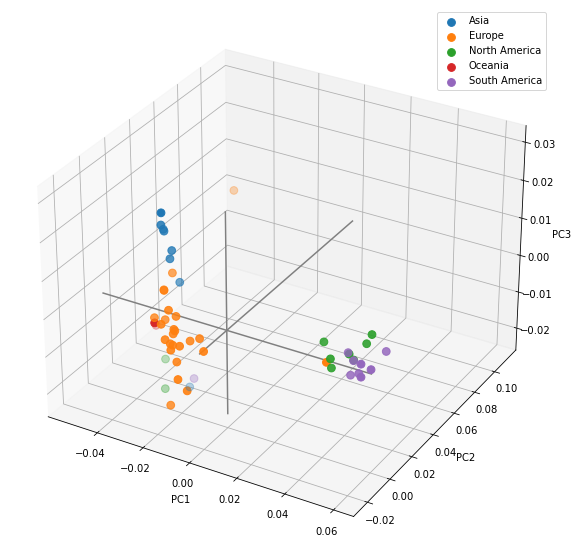

In [674]:
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

label = df_cluster_pca_kmeans['Continent']
uniq = np.unique(label)
for i in uniq:
   ax.scatter(df_cluster_pca_kmeans.PC1[label == i], 
              df_cluster_pca_kmeans.PC2[label == i], 
              df_cluster_pca_kmeans.PC3[label == i], 
              s=60, label = i)

# make simple, bare axis lines through space:
xAxisLine = ((min(df_cluster_pca_kmeans.PC1), max(df_cluster_pca_kmeans.PC1)), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'grey')
yAxisLine = ((0, 0), (min(df_cluster_pca_kmeans.PC2), max(df_cluster_pca_kmeans.PC2)), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'grey')
zAxisLine = ((0, 0), (0,0), (min(df_cluster_pca_kmeans.PC3), max(df_cluster_pca_kmeans.PC3)))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'grey')

# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()

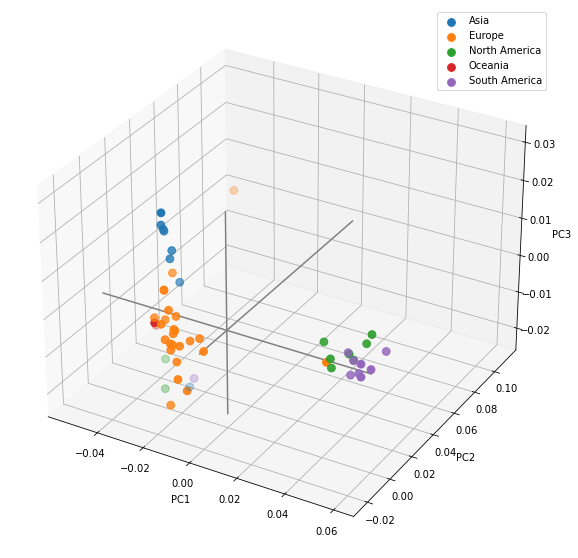

In [636]:
# Plot initialisation
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

label = pca_results['Continent']
uniq = np.unique(label)
for i in uniq:
   ax.scatter(pca_results.f1[label == i], 
               pca_results.f2[label == i], 
               pca_results.f3[label == i], 
               s=60, label = i)

# make simple, bare axis lines through space:
xAxisLine = ((min(pca_results.f1), max(pca_results.f1)), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'grey')
yAxisLine = ((0, 0), (min(pca_results.f2), max(pca_results.f2)), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'grey')
zAxisLine = ((0, 0), (0,0), (min(pca_results.f3), max(pca_results.f3)))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'grey')

# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.legend()
plt.show()

In [375]:
# Calculate 2 PCA components for visualization
pca = PCA(n_components=2)
pca_features = pca.fit_transform(cluster)
Region_code = cluster.index
pca_results = pd.DataFrame(pca_features, columns=['f1', 'f2'])
pca_results['Region Code'] = Region_code
pca_results['Continent'] = pca_results['Region Code'].apply(getContinentName)
pca_results['Region Name'] = pca_results['Region Code'].apply(getRegionName)

# Replace the abbreviation of continent with corresponding full names
pca_results['Continent'] = pca_results['Continent'].replace({'AS':'Asia', 'EU':'Europe', 'NA':'North America',
                                          'OC':'Oceania','SA':'South America'})

# Reduce the length of some region names
pca_results['Region'] = pca_results['Region Name'].replace({'Bolivia, Plurinational State of':'Bolivia', 
                                     'Taiwan, Province of China':'Taiwan',
                                     'United States':'United States of America'})

pca_results =  pca_results.loc[(pca_results['Continent'] != 'Global')]
pca_results

,f1,f2,Region Code,Continent,Region Name,Region
0,0.053687,0.002267,AR,South America,Argentina,Argentina
1,-0.019797,-0.006728,AT,Europe,Austria,Austria
2,-0.024785,-0.011558,AU,Oceania,Australia,Australia
3,-0.021072,-0.003217,BE,Europe,Belgium,Belgium
4,0.059860,0.012930,BO,South America,"Bolivia, Plurinational State of",Bolivia
5,-0.002579,-0.022316,BR,South America,Brazil,Brazil
6,-0.021079,-0.010443,CA,North America,Canada,Canada
7,-0.016166,0.000599,CH,Europe,Switzerland,Switzerland
8,0.055789,-0.000266,CL,South America,Chile,Chile
9,0.047901,0.005299,CO,South America,Colombia,Colombia


Text(0.5, 1.0, 'PCA two-dimensional features')

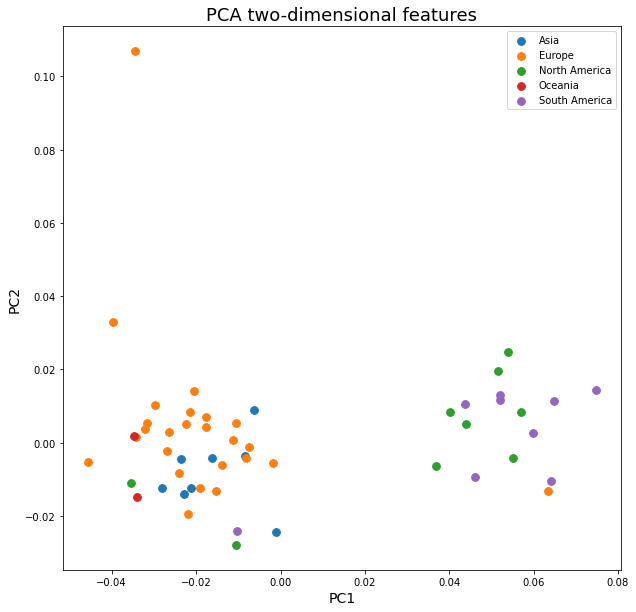

In [376]:
# visualize the 2 PCA components
mpl.rcParams['figure.figsize'] = (10, 10)

# Add randomness to jittering the points slighty to advoid overlaped scatter plot
pca_results['PC1'] = pca_results.f1 + np.random.normal(0, 0.008, len(pca_results.f1))
pca_results['PC2'] = pca_results.f2 + np.random.normal(0, 0.008, len(pca_results.f2))
# ax = pca_results.plot('f1', 'f2', kind='scatter')
# pca_results[['f1','f2','Continent']].apply(lambda x: ax.text(*x, rotation=30),axis=1)
# plt.title('PCA two-dimensional features')

label = pca_results['Continent']
uniq = np.unique(label)
for i in uniq:
   plt.scatter(pca_results['PC1'][label == i], pca_results['PC2'][label == i], s=60, label = i)
plt.ylabel('PC2', size=14)
plt.xlabel('PC1', size=14)
plt.legend()
plt.title('PCA two-dimensional features', size=18)

This chart runs PCA on the features to be able to visualize the features in two dimensions. It divide the data into about two clusters. It's clear that Latin American Spanish speaking regions have similar characteristics and are clustered together. Arguably there is also an European cluster of some sort.

### For each cluster

In [377]:
pca_results

,f1,f2,Region Code,Continent,Region Name,Region,PC1,PC2
0,0.053687,0.002267,AR,South America,Argentina,Argentina,0.052035,0.011597
1,-0.019797,-0.006728,AT,Europe,Austria,Austria,-0.019156,-0.012367
2,-0.024785,-0.011558,AU,Oceania,Australia,Australia,-0.034114,-0.014831
3,-0.021072,-0.003217,BE,Europe,Belgium,Belgium,-0.045557,-0.005174
4,0.059860,0.012930,BO,South America,"Bolivia, Plurinational State of",Bolivia,0.064772,0.011470
5,-0.002579,-0.022316,BR,South America,Brazil,Brazil,-0.010225,-0.024171
6,-0.021079,-0.010443,CA,North America,Canada,Canada,-0.035499,-0.011033
7,-0.016166,0.000599,CH,Europe,Switzerland,Switzerland,-0.020573,0.014045
8,0.055789,-0.000266,CL,South America,Chile,Chile,0.064127,-0.010363
9,0.047901,0.005299,CO,South America,Colombia,Colombia,0.043668,0.010539


In [388]:
### Select ranges for the three major clusters

# GroupA represent Eurasia continent
groupA = pca_results[(pca_results['PC2'] <= 0.04) & (pca_results['PC1'] < 0.02)]

# GroupB represent America continent
groupB = pca_results[pca_results['PC1'] > 0.02] 

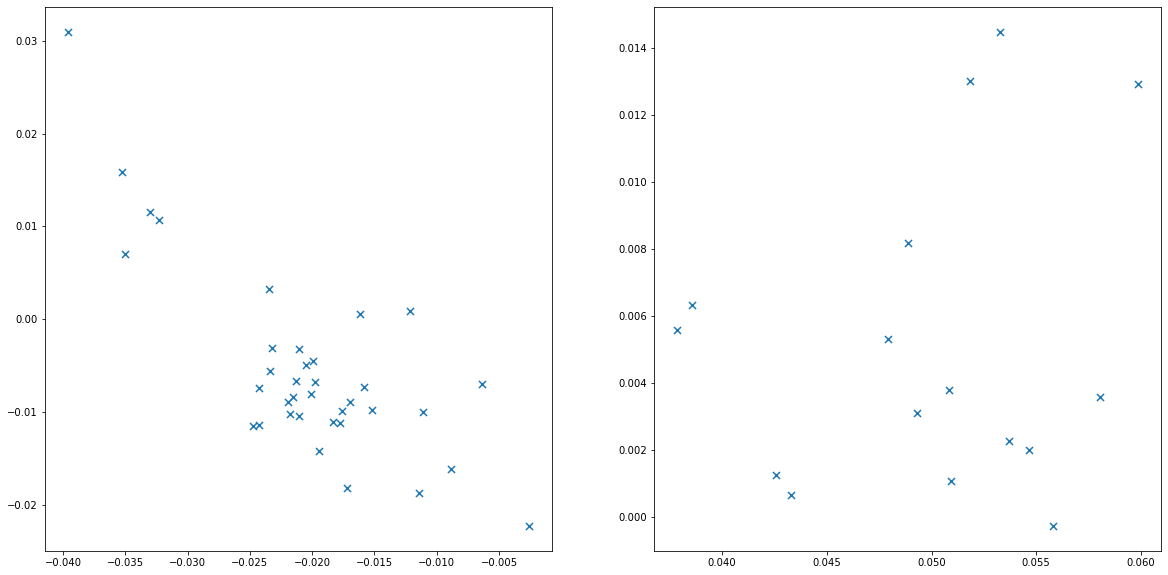

In [589]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.scatter(groupA['f1'], groupA['f2'], s=50, marker='x')
# groupA['f1','f2','Region']].apply(lambda x: ax1.text(*x, rotation=30, fontsize=10),axis=1)

ax2.scatter(groupB['f1'], groupB['f2'], s=50, marker='x')
# groupB['f1','f2','Region']].apply(lambda x: ax2.text(*x),axis=1)



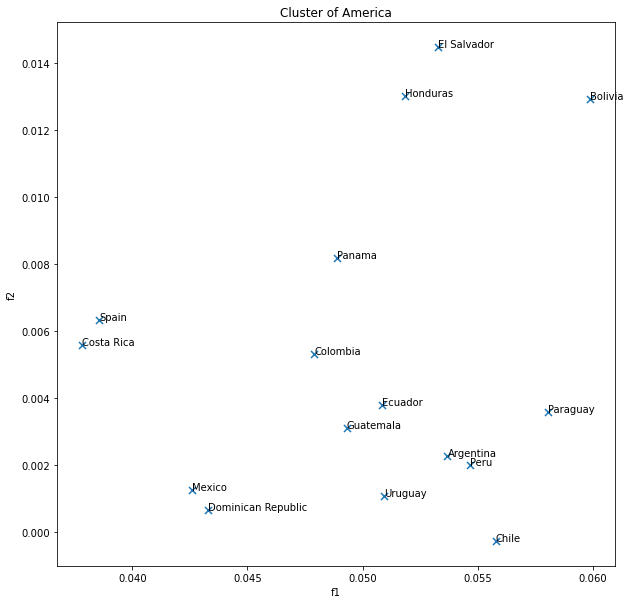

In [390]:
ax = groupB.plot('f1', 'f2', kind='scatter', s=50, marker='x')
groupB[['f1','f2','Region']].apply(lambda x: ax.text(*x),axis=1)
plt.title('Cluster of America')
plt.savefig('GroupA.png')

Text(0.5, 1.0, 'Cluster of Eurasia')

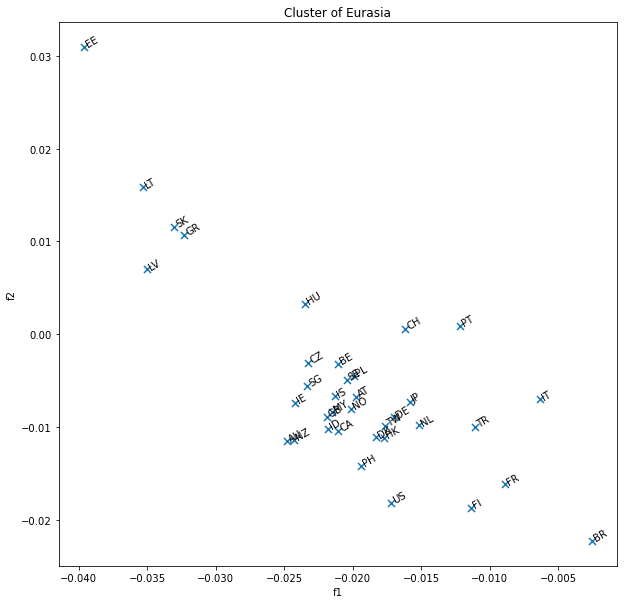

In [393]:
# ax = groupB.plot('f1', 'f2', kind='scatter', s=50, marker='x')
# groupB[['f1','f2','Region']].apply(lambda x: ax.text(*x),axis=1);
# plt.title('Cluster of Eurasia')
ax = groupA.plot('f1', 'f2', kind='scatter', s=50, marker='x')
groupA[['f1','f2','Region Code']].apply(lambda x: ax.text(*x, rotation=30, fontsize=10),axis=1)
plt.title('Cluster of Eurasia')

### K means with PCA